**Deep Learning Tutorial**,  Mehr 29 at 18:00 via Skype Class Room, DL Recitation, Session Six

[Deep Learning](https://github.com/hhaji/Deep-Learning), Data Science Center, Shahid Beheshti University

Presented and prepared by [‌‌Yavar Yeganeh](https://github.com/YavarYeganeh)




**Acknowledgment and References:**

* [Pytorch](www.Pytorch.org)

* [Deep Learning with PyTorch](https://www.manning.com/books/deep-learning-with-pytorch) by Eli Stevens and Luca Antiga  

* [Programming PyTorch for Deep Learning](https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/) by Ian Pointer 

* https://github.com/rasbt/stat479-deep-learning-ss19

* https://githubz.com/topics/semi-supervised-learning

* https://github.com/pytorch/examples/tree/master/mnist

* https://pytorch.org/docs/stable/torchvision/transforms.html

* https://github.com/aleju/imgaug

* https://github.com/fabioperez/pytorch-examples/

* https://gist.github.com/yang-zhang/ec071ae4775c2125595fd80f40efb0d6

* https://medium.com/@zhang_yang/multi-task-deep-learning-experiment-using-fastai-pytorch-2b5e9d078069


<table align="left">
  <td>
    <a target="_blank" href=https://colab.research.google.com/drive/1jzfsfwkAVsnd0-wO_Xtfx28O3oUhWyLk?usp=sharing"><img src="https://colab.research.google.com/img/colab_favicon_256px.png" height="100" width="100" /> <br>  Run in Google Colab</a>
  </td>
</table>

# L1 and L2 Regularization

* Let's start with a basic example: how to implement L2 

In [ ]:
# This example is borrowed from:  Sebastian Raschka (sraschka@wisc.edu)
#GitHub repository: https://github.com/rasbt/stat479-deep-learning-ss19


%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn.functional as F

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
LAMBDA = 2

In [ ]:
# Downloading dataset

!wget https://raw.githubusercontent.com/rasbt/stat479-deep-learning-ss19/master/L10_regularization/code/data/toydata.txt
!ls


--2020-10-20 06:02:55--  https://raw.githubusercontent.com/rasbt/stat479-deep-learning-ss19/master/L10_regularization/code/data/toydata.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1287 (1.3K) [text/plain]
Saving to: ‘toydata.txt.1’

toydata.txt.1       100%[===================>]   1.26K  --.-KB/s    in 0s      

2020-10-20 06:02:55 (109 MB/s) - ‘toydata.txt.1’ saved [1287/1287]

sample_data  toydata.txt  toydata.txt.1


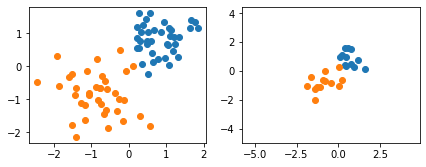

In [ ]:
##########################
### DATASET
##########################

data = np.genfromtxt('toydata.txt', delimiter='\t') 
# we could generate random samples: np.random.randn(100,3)
x = data[:, :2].astype(np.float32)
y = data[:, 2].astype(np.int64)

np.random.seed(123)
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X_test, y_test = x[idx[:25]], y[idx[:25]]
X_train, y_train = x[idx[25:]], y[idx[25:]]
mu, std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train, X_test = (X_train - mu) / std, (X_test - mu) / std

fig, ax = plt.subplots(1, 2, figsize=(7, 2.5))
ax[0].scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1])
ax[0].scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1])
ax[1].scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1])
ax[1].scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1])
plt.xlim([x[:, 0].min()-0.5, x[:, 0].max()+0.5])
plt.ylim([x[:, 1].min()-0.5, x[:, 1].max()+0.5])
plt.show()

In [ ]:
def custom_where(cond, x_1, x_2):
    return (cond * x_1) + ((1-cond) * x_2)


class LogisticRegression(torch.nn.Module):

    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(num_features, 1)
        # initialize weights to zeros here,
        # since we used zero weights in the
        # manual approach
        
        self.linear.weight.detach().zero_()
        self.linear.bias.detach().zero_()
        # Note: the trailing underscore
        # means "in-place operation" in the context
        # of PyTorch
        
    def forward(self, x):
        logits = self.linear(x)
        probas = torch.sigmoid(logits)
        return probas

model = LogisticRegression(num_features=2).to(device)

#########################################################
## Apply L2 regularization
optimizer = torch.optim.SGD(model.parameters(), 
                            lr=0.1, 
                            weight_decay=LAMBDA)
#-------------------------------------------------------


def comp_accuracy(label_var, pred_probas): #
    pred_labels = custom_where((pred_probas > 0.5).float(), 1, 0).view(-1)
    acc = torch.sum(pred_labels == label_var.view(-1)).float() / label_var.size(0)
        return acc


num_epochs = 30

X_train_tensor = torch.tensor(X_train, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device).view(-1, 1)


for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model(X_train_tensor)
    
    #### Compute gradients ####
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))


    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('\n\nTest set accuracy: %.2f%%' % (test_acc*100))

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.065
Epoch: 003 | Train ACC: 0.973 | Cost: 0.080
Epoch: 004 | Train ACC: 0.973 | Cost: 0.094
Epoch: 005 | Train ACC: 0.973 | Cost: 0.104
Epoch: 006 | Train ACC: 0.973 | Cost: 0.108
Epoch: 007 | Train ACC: 0.973 | Cost: 0.110
Epoch: 008 | Train ACC: 0.973 | Cost: 0.111
Epoch: 009 | Train ACC: 0.973 | Cost: 0.112
Epoch: 010 | Train ACC: 0.973 | Cost: 0.112
Epoch: 011 | Train ACC: 0.973 | Cost: 0.112
Epoch: 012 | Train ACC: 0.973 | Cost: 0.112
Epoch: 013 | Train ACC: 0.973 | Cost: 0.112
Epoch: 014 | Train ACC: 0.973 | Cost: 0.112
Epoch: 015 | Train ACC: 0.973 | Cost: 0.112
Epoch: 016 | Train ACC: 0.973 | Cost: 0.112
Epoch: 017 | Train ACC: 0.973 | Cost: 0.112
Epoch: 018 | Train ACC: 0.973 | Cost: 0.112
Epoch: 019 | Train ACC: 0.973 | Cost: 0.112
Epoch: 020 | Train ACC: 0.973 | Cost: 0.112
Epoch: 021 | Train ACC: 0.973 | Cost: 0.112
Epoch: 022 | Train ACC: 0.973 | Cost: 0.112
Epoch: 023 | Train ACC: 0.973 | 

In [ ]:
model = LogisticRegression(num_features=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model(X_train_tensor)
    
    #### Compute gradients ####
    
    #########################################################
    ## Apply L2 regularization (weight decay)
    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
    cost = cost + 0.5 * LAMBDA * torch.mm(model.linear.weight,
                                          model.linear.weight.t())
    
    # note that PyTorch also regularizes the bias, hence, if we want
    # to reproduce the behavior of SGD's "weight_decay" param, we have to add
    # the bias term as well: 
    cost = cost + 0.5 * LAMBDA * model.linear.bias**2
    #-------------------------------------------------------
    
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))


    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('\n\nTest set accuracy: %.2f%%' % (test_acc*100))

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.065
Epoch: 003 | Train ACC: 0.973 | Cost: 0.080
Epoch: 004 | Train ACC: 0.973 | Cost: 0.094
Epoch: 005 | Train ACC: 0.973 | Cost: 0.104
Epoch: 006 | Train ACC: 0.973 | Cost: 0.108
Epoch: 007 | Train ACC: 0.973 | Cost: 0.110
Epoch: 008 | Train ACC: 0.973 | Cost: 0.111
Epoch: 009 | Train ACC: 0.973 | Cost: 0.112
Epoch: 010 | Train ACC: 0.973 | Cost: 0.112
Epoch: 011 | Train ACC: 0.973 | Cost: 0.112
Epoch: 012 | Train ACC: 0.973 | Cost: 0.112
Epoch: 013 | Train ACC: 0.973 | Cost: 0.112
Epoch: 014 | Train ACC: 0.973 | Cost: 0.112
Epoch: 015 | Train ACC: 0.973 | Cost: 0.112
Epoch: 016 | Train ACC: 0.973 | Cost: 0.112
Epoch: 017 | Train ACC: 0.973 | Cost: 0.112
Epoch: 018 | Train ACC: 0.973 | Cost: 0.112
Epoch: 019 | Train ACC: 0.973 | Cost: 0.112
Epoch: 020 | Train ACC: 0.973 | Cost: 0.112
Epoch: 021 | Train ACC: 0.973 | Cost: 0.112
Epoch: 022 | Train ACC: 0.973 | Cost: 0.112
Epoch: 023 | Train ACC: 0.973 | 

In [ ]:
model = LogisticRegression(num_features=2).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

for epoch in range(num_epochs):
    
    #### Compute outputs ####
    out = model(X_train_tensor)
    
    #### Compute gradients ####
    

    cost = F.binary_cross_entropy(out, y_train_tensor, reduction='sum')
  
  
    
    optimizer.zero_grad()
    cost.backward()
    
    #### Update weights ####  
    optimizer.step()
    
    #### Logging ####      
    pred_probas = model(X_train_tensor)
    acc = comp_accuracy(y_train_tensor, pred_probas)
    print('Epoch: %03d' % (epoch + 1), end="")
    print(' | Train ACC: %.3f' % acc, end="")
    print(' | Cost: %.3f' % F.binary_cross_entropy(pred_probas, y_train_tensor))


    
print('\nModel parameters:')
print('  Weights: %s' % model.linear.weight)
print('  Bias: %s' % model.linear.bias)


X_test_tensor = torch.tensor(X_test, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

pred_probas = model(X_test_tensor)
test_acc = comp_accuracy(y_test_tensor, pred_probas)

print('\n\nTest set accuracy: %.2f%%' % (test_acc*100))

Epoch: 001 | Train ACC: 0.973 | Cost: 0.055
Epoch: 002 | Train ACC: 0.973 | Cost: 0.053
Epoch: 003 | Train ACC: 0.973 | Cost: 0.051
Epoch: 004 | Train ACC: 0.973 | Cost: 0.049
Epoch: 005 | Train ACC: 0.973 | Cost: 0.048
Epoch: 006 | Train ACC: 0.973 | Cost: 0.047
Epoch: 007 | Train ACC: 0.973 | Cost: 0.046
Epoch: 008 | Train ACC: 0.973 | Cost: 0.045
Epoch: 009 | Train ACC: 0.973 | Cost: 0.044
Epoch: 010 | Train ACC: 0.987 | Cost: 0.043
Epoch: 011 | Train ACC: 0.987 | Cost: 0.042
Epoch: 012 | Train ACC: 0.987 | Cost: 0.041
Epoch: 013 | Train ACC: 0.987 | Cost: 0.041
Epoch: 014 | Train ACC: 0.987 | Cost: 0.040
Epoch: 015 | Train ACC: 0.987 | Cost: 0.039
Epoch: 016 | Train ACC: 0.987 | Cost: 0.039
Epoch: 017 | Train ACC: 1.000 | Cost: 0.038
Epoch: 018 | Train ACC: 1.000 | Cost: 0.038
Epoch: 019 | Train ACC: 1.000 | Cost: 0.037
Epoch: 020 | Train ACC: 1.000 | Cost: 0.036
Epoch: 021 | Train ACC: 1.000 | Cost: 0.036
Epoch: 022 | Train ACC: 1.000 | Cost: 0.036
Epoch: 023 | Train ACC: 1.000 | 

* L1 and L2 Norms

In [ ]:
# Modified based on https://github.com/pytorch/examples/tree/master/mnist

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
       # self.dropout1 = nn.Dropout(0.25)
       # self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
       # x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
       # x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output


def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))



In [ ]:
    torch.manual_seed(112)
    device =torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
    dataset_train = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
    dataset_test = datasets.MNIST('../data', train=False,
                       transform=transform)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
dataset_train, dataset_test

(Dataset MNIST
     Number of datapoints: 60000
     Root location: ../data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ), Dataset MNIST
     Number of datapoints: 10000
     Root location: ../data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=(0.1307,), std=(0.3081,))
            ))

In [ ]:
torch.manual_seed(123)
transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                       transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                       transform=transform)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=256 , shuffle=True,
        num_workers=1,pin_memory=True)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=256 , shuffle=True,
        num_workers=1,pin_memory=True)

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1 )
for epoch in range(1, 20 + 1):
  train(10, model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

torch.save(model.state_dict(), "mnist_1.pt")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307113
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.246330
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.152776
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.053525
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.883935
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.724492
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.479796
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.235827
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.034860
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.853716
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.772773
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.717264
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.640164
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.587384
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.539963
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.491984
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.530113
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.548230
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.513601
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.443843
Train Epoc

In [ ]:
device

device(type='cuda')

In [ ]:
#L2 norm
lmbd=0.001
def train_l2(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        ####
        reg_loss = None
        for param in model.parameters():
          if reg_loss is None:
            reg_loss =  torch.sum(param**2)
          else:
            reg_loss = reg_loss + param.norm(2)**2
        loss += lmbd * reg_loss
        ###
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1 )
for epoch in range(1, 10 + 1):
  train_l2(10, model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

torch.save(model.state_dict(), "mnist_2.pt")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.391648
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.341704
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.292534
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.208622
Train Epoch: 1 [10240/60000 (17%)]	Loss: 2.125132
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.006788
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.846633
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.670675
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.439767
Train Epoch: 1 [23040/60000 (38%)]	Loss: 1.271197
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.064669
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.998135
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.852729
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.734327
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.722804
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.709951
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.536799
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.531639
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.550514
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.545297
Train Epoc

In [ ]:
#L1 norm
lmbd=0.001
l1_loss = nn.L1Loss()
def train_l1(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        ####
        reg_loss = None
        for param in model.parameters():
          if reg_loss is None:
            reg_loss =  l1_loss(param,0)
          else:
            reg_loss = reg_loss + l1_loss(param,0)
        loss += lmbd * reg_loss
        ###
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))

model = Net().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=0.01)

scheduler = StepLR(optimizer, step_size=5, gamma=0.1 )
for epoch in range(1, 10 + 1):
  train_l2(10, model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)
  scheduler.step()

torch.save(model.state_dict(), "mnist_3.pt")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.379181
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.315037
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.225310
Train Epoch: 1 [7680/60000 (13%)]	Loss: 2.094048
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.961995
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.805493
Train Epoch: 1 [15360/60000 (26%)]	Loss: 1.595724
Train Epoch: 1 [17920/60000 (30%)]	Loss: 1.355338
Train Epoch: 1 [20480/60000 (34%)]	Loss: 1.212960
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.975813
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.860789
Train Epoch: 1 [28160/60000 (47%)]	Loss: 0.853016
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.747586
Train Epoch: 1 [33280/60000 (55%)]	Loss: 0.672132
Train Epoch: 1 [35840/60000 (60%)]	Loss: 0.623093
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.546806
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.557932
Train Epoch: 1 [43520/60000 (72%)]	Loss: 0.622950
Train Epoch: 1 [46080/60000 (77%)]	Loss: 0.528889
Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.504508
Train Epoc

# Data Augmentation
* See this first: https://pytorch.org/docs/stable/torchvision/transforms.html

* First a basic example


In [ ]:
# Borrowed from Sebastian Raschka (sraschka@wisc.edu)
# http://pages.stat.wisc.edu/~sraschka/teaching/stat479-ss2019/
from torchvision import datasets
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch
import PIL

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 1
BATCH_SIZE = 128
NUM_EPOCHS = 100

##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range

training_transforms = torchvision.transforms.Compose([
    #torchvision.transforms.RandomRotation(degrees=20),
    #torchvision.transforms.Resize(size=(34, 34)),
    #torchvision.transforms.RandomCrop(size=(28, 28)),
    torchvision.transforms.RandomAffine(degrees=(-30, 30), translate=(0.25, 0.25),
                                        resample=PIL.Image.BILINEAR),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=(0.5), std=(0.5)),

    # normalize does (x_i - mean) / std
    # if images are [0, 1], they will be [-1, 1] afterwards
])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize(mean=(0.5), std=(0.5)),
])

# for more see
# https://pytorch.org/docs/stable/torchvision/transforms.html

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=training_transforms,
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=test_transforms)


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False)


Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128])


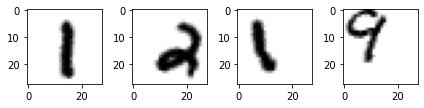

In [ ]:
torch.manual_seed(123)

for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(images[i].view(28, 28).numpy(), cmap='binary')
    
plt.tight_layout()


Image batch dimensions: torch.Size([128, 1, 28, 28])
Image label dimensions: torch.Size([128]) 



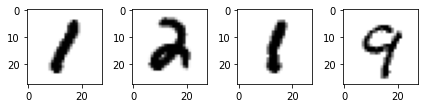

In [ ]:
# compare without augmentation

train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=torchvision.transforms.ToTensor(),
                               download=True)

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

torch.manual_seed(123)
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape, '\n')
    break
    
fig, ax = plt.subplots(1, 4)
for i in range(4):
    ax[i].imshow(images[i].view(28, 28).numpy(), cmap='binary')
    
plt.tight_layout()


# A more advanced example 

Data Augmentation for Computer Vision with PyTorch)


In [ ]:
# Borrowed from https://github.com/fabioperez/pytorch-examples/

#!pip3 install 'torch==0.4.0'
#!pip3 install 'torchvision==0.2.1'
#!pip3 install --no-cache-dir -I 'pillow==5.1.0'

# Restart Kernel
# This workaround is needed to properly upgrade PIL on Google Colab.
#import os
#os._exit(00)

Next, import all libraries and configure matplotlib to display larger plots.

In [ ]:
import PIL
import numpy as np
import torch
import torchvision

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['axes.grid'] = False
mpl.rcParams['image.interpolation'] = 'nearest'
mpl.rcParams['figure.figsize'] = 15, 25

def show_dataset(dataset, n=6):
  img = np.vstack((np.hstack((np.asarray(dataset[i][0]) for _ in range(n)))
                   for i in range(len(dataset))))
  plt.imshow(img)
  plt.axis('off')

We need some sample images to perform augmentation. Let's import them from the pytorch-examples repository.

In [ ]:
!git clone https://github.com/fabioperez/pytorch-examples/

fatal: destination path 'pytorch-examples' already exists and is not an empty directory.


Augmenting data with PyTorch is very straightforward. We can use the transforms provided in torchvision: [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html).

To compose several transforms together, we use [`torchvision.transforms.Compose`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Compose) and pass the transforms as a list. The transforms are applied following the list order.

**Important note**

For training we should probably also add [`transforms.ToTensor`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor) to convert the images to a PyTorch Tensor and [`transforms.Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) to normalize the images according to the network that you will train. I'm omitting these steps since my focus for this tutorial is to display the augmented images.


In [ ]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR)
])

We then pass the transforms to [`torchvision.datasets.ImageFolder`](https://pytorch.org/docs/master/torchvision/datasets.html#imagefolder) and the images will be automatically augmented.

If you want to define your own [dataset](https://pytorch.org/docs/master/torchvision/datasets.html) class, you just have to call `transforms(samples)` to perform the transforms on your samples. Check the source code for [`ImageFolder`](https://github.com/pytorch/vision/blob/4db0398a2b02aae790013efbc868f2d795eb2ef7/torchvision/datasets/folder.py#L150) for more details.

In [ ]:
dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

That's all! Let's visualize some of the transformed images:

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  # This is added back by InteractiveShellApp.init_path()


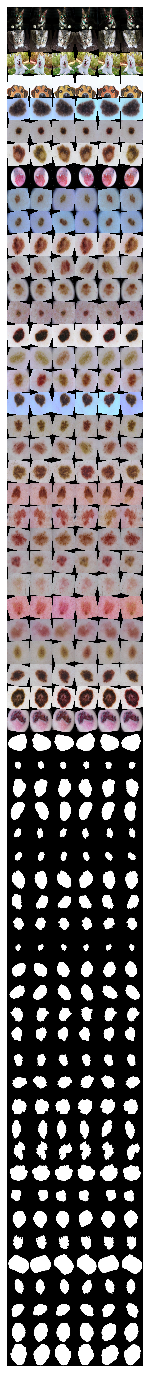

In [ ]:
show_dataset(dataset)

Ok, but the augmentations available on PyTorch are very simple. What if we want to perform more interesting augmentations?

Let's use [imgaug](https://github.com/aleju/imgaug) to achieve that.

In [ ]:
!pip install git+https://github.com/aleju/imgaug
from imgaug import augmenters as iaa
import imgaug as ia

We can perform more complex augmentation and define more complex behaviors with imgaug.

Besides having more image transformation techniques, imgaug also has interesting behaviors such as [`Sometimes`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#sometimes), [`SomeOf`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#someof) and [`OneOf`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#oneof).

Note that for imgaug, we should convert the PIL images to NumPy arrays before applying the transforms.

You should always be careful with the `dtype` and dimension ordering when applying data augmentation and training neural networks. It's a good practice to visualize the augmented images and print some of the input values before training a neural network.

In [ ]:
class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.Sometimes(0.25, iaa.GaussianBlur(sigma=(0, 3.0))),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='symmetric'),
        iaa.Sometimes(0.25,
                      iaa.OneOf([iaa.Dropout(p=(0, 0.1)),
                                 iaa.CoarseDropout(0.1, size_percent=0.5)])),
        iaa.AddToHueAndSaturation(value=(-10, 10), per_channel=True)
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms = ImgAugTransform()

dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

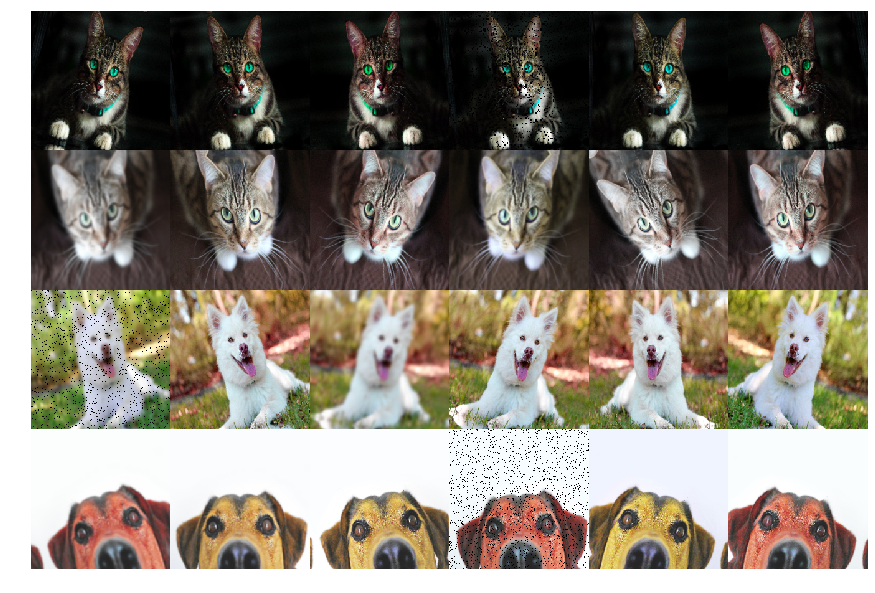

In [ ]:
show_dataset(dataset)

imgaug also accepts a list of images instead of a single image. To augment them, use `aug.augment_images`. This may be useful if you are implementing a custom dataset that will load several images at once, before augmenting them. 

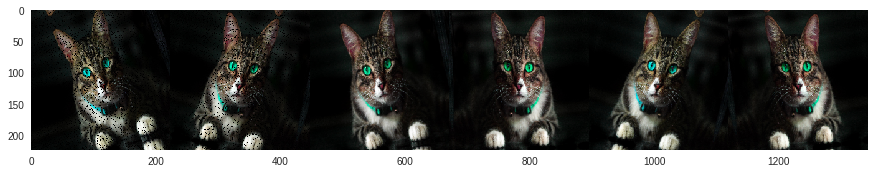

In [ ]:
aug = iaa.Affine(rotate=(-40, 40), mode='symmetric')
imgs = [np.asarray(dataset[0][0]) for _ in range(6)]
aug.augment_images(imgs)
plt.imshow(np.hstack(imgs))

If you want to create your own image transformations, you just have to write a Python function that will transform the given image (or images) and use it with [`transforms.Lambda`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Lambda), [`iaa.Lambda`](http://imgaug.readthedocs.io/en/latest/source/augmenters.html#lambda), or to call it directly in a custom transform class.

Mixing PyTorch and imgaug transforms is also very simple:

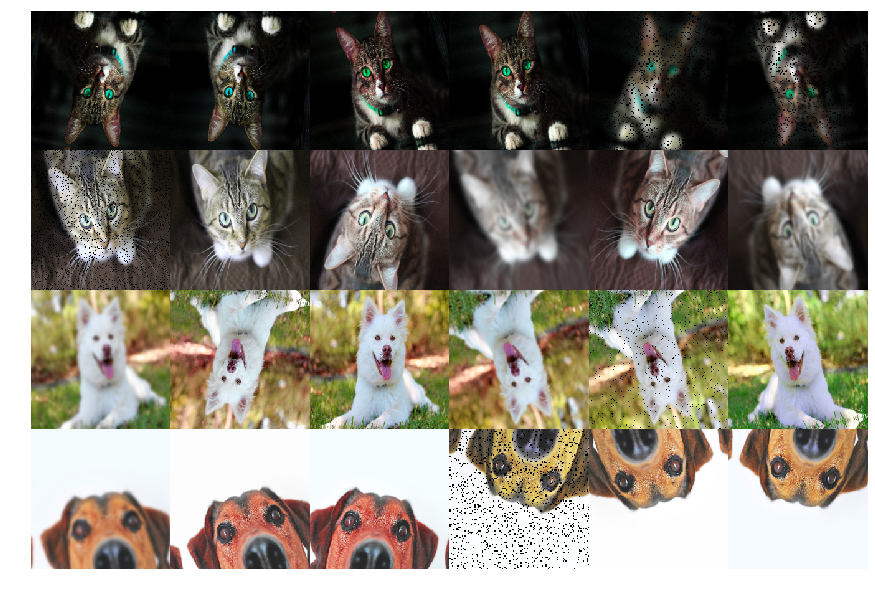

In [ ]:
transforms = torchvision.transforms.Compose([
    ImgAugTransform(),
    lambda x: PIL.Image.fromarray(x),
    torchvision.transforms.RandomVerticalFlip()
])

dataset = torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms)

show_dataset(dataset)

# Time

Let's perform a simple benchmark to compare the running time for imgaug and for PyTorch. We can see that the results are very similar for the same augmentation techniques.

In [ ]:
import time

transforms_pytorch = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224,224)),
    torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20)
])

class ImgAugTransform:
  def __init__(self):
    self.aug = iaa.Sequential([
        iaa.Scale((224, 224)),
        iaa.AddToHueAndSaturation(value=(-20, 20), per_channel=True),
        iaa.Fliplr(0.5),
        iaa.Affine(rotate=(-20, 20), mode='constant'),
    ])
      
  def __call__(self, img):
    img = np.array(img)
    return self.aug.augment_image(img)

transforms_imgaug = ImgAugTransform()

datasets = {
'pytorch': torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms_pytorch),
'imgaug' : torchvision.datasets.ImageFolder('pytorch-examples/data/', transform=transforms_imgaug)
}

times = {'pytorch': [], 'imgaug': []}
for _ in range(20):
  for mode in ('pytorch', 'imgaug'):
    start = time.time()
    img_pytorch = np.vstack((np.hstack((np.asarray(datasets[mode][i][0]) for _ in range(6))) for i in range(4)))
    end = time.time()
    times[mode].append(end - start)
    
for mode in ('pytorch', 'imgaug'):
  t = np.array(times[mode])
  print("{}: {:.04f}".format(mode, t.min()))

pytorch: 10.6141
imgaug: 10.7446


# Multi Task Learning
* See this for Semi Supervised Learning https://githubz.com/topics/semi-supervised-learning

# An Introductory *example*

In [ ]:
# Thanks to https://towardsdatascience.com/multi-task-learning-with-pytorch-and-fastai-6d10dc7ce855
!wget -O data.zip "https://storage.googleapis.com/kaggle-data-sets/44109/78156/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1589918979&Signature=oOJ6FnnAn37CKLuFVFo5uCJ8bn2W3fMorVfIxrmKyVUwyhY11ieaFWWOZfO20cvXFsGEz278b1ny6ozhH5ud27qInmTfoxkntemUGfIFPDruYUvHTa1%2BEBDrUbwOu2kDP2PTWlUu%2FqiQ%2BIMgWtiFcQRnYyntmv7rArWEQkJiK4EEKRUG5f0mVvjfha8BZKSJg0kcjdXKUwyyB6fqyXgRZMPZLhfBR54Hz5n9eWRsCLLCjsbvKZSbjWemk8rebzBCCNBp7%2BQRdtr2ORwh%2FZElApGISTHtc5blxo9SdSIKJTNeypIFGBIrwUkeqZbvxozEsMEvRFpHilR3tL9u1M%2FQsg%3D%3D&response-content-disposition=attachment%3B+filename%3Dutkface-new.zip"
!unzip data.zip

# 1. Reading the data

In [ ]:
from fastai import *
from fastai.vision import *
from fastai.layers import MSELossFlat, CrossEntropyFlat
from torchvision import transforms
import warnings
warnings.filterwarnings("ignore")

In [ ]:
files_train = get_image_files("utkface_aligned_cropped/UTKFace")
files_valid = get_image_files("utkface_aligned_cropped/crop_part1")

In [ ]:
len(files_train), len(files_valid)

(23708, 9780)

In [ ]:
df_train = pd.DataFrame(files_train,columns=["name"])
df_train.name = df_train.name.apply(str)
df_train["label"] = df_train.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_train["label"] = df_train.label.apply(lambda x: re.sub("_"," ", x))
df_train["age"] = df_train.label.apply(lambda x: int(x.split(" ")[0]))
df_train["gender"] = df_train.label.apply(lambda x: int(x.split(" ")[1]))
df_train["ethnicity"] = df_train.label.apply(lambda x: int(x.split(" ")[2]))

In [ ]:
df_valid = pd.DataFrame(files_valid,columns=["name"])
df_valid.name = df_valid.name.apply(str)
df_valid["label"] = df_valid.name.apply(lambda x: re.findall(r"\d{1,3}_\d_\d",x)[0])
df_valid["label"] = df_valid.label.apply(lambda x: re.sub("_"," ", x))
df_valid["age"] = df_valid.label.apply(lambda x: int(x.split(" ")[0]))
df_valid["gender"] = df_valid.label.apply(lambda x: int(x.split(" ")[1]))
df_valid["ethnicity"] = df_valid.label.apply(lambda x: int(x.split(" ")[2]))

In [ ]:
df_train.head()

name   label  ...  gender  ethnicity
0  utkface_aligned_cropped/UTKFace/35_1_3_2017011...  35 1 3  ...       1          3
1  utkface_aligned_cropped/UTKFace/27_0_0_2017010...  27 0 0  ...       0          0
2  utkface_aligned_cropped/UTKFace/27_0_2_2017011...  27 0 2  ...       0          2
3  utkface_aligned_cropped/UTKFace/1_0_0_20161219...   1 0 0  ...       0          0
4  utkface_aligned_cropped/UTKFace/30_0_0_2017011...  30 0 0  ...       0          0

[5 rows x 5 columns]

In [ ]:
df_valid.head()

name   label  ...  gender  ethnicity
0  utkface_aligned_cropped/crop_part1/27_0_0_2017...  27 0 0  ...       0          0
1  utkface_aligned_cropped/crop_part1/1_0_0_20161...   1 0 0  ...       0          0
2  utkface_aligned_cropped/crop_part1/45_0_0_2017...  45 0 0  ...       0          0
3  utkface_aligned_cropped/crop_part1/2_1_2_20161...   2 1 2  ...       1          2
4  utkface_aligned_cropped/crop_part1/44_1_2_2017...  44 1 2  ...       1          2

[5 rows x 5 columns]

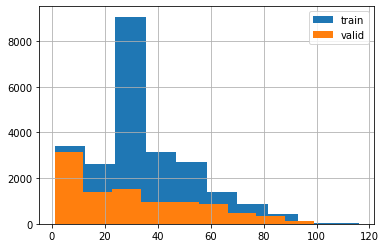

In [ ]:
#checking distribution for ages
df_train.age.hist()
df_valid.age.hist()
plt.legend(["train","valid"]);

In [ ]:
#should be only 0s and 1s
df_train.gender.unique(), df_valid.gender.unique()

(array([1, 0]), array([0, 1, 3]))

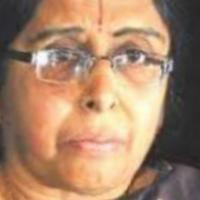

In [ ]:
#checking the mislabeled image
open_image(df_valid[df_valid.gender == 3].name.iloc[0])

In [ ]:
#fixing the label
idx = df_valid[df_valid.gender == 3].index
df_valid.loc[idx,"gender"] = 1 #1 means woman

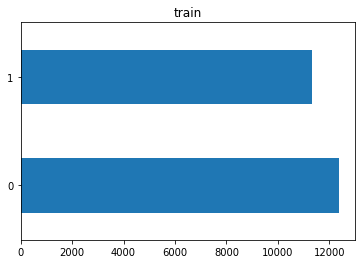

In [ ]:
#accuracy is a good metric fore gender
(df_train.gender.value_counts()).plot.barh()
plt.title("train");

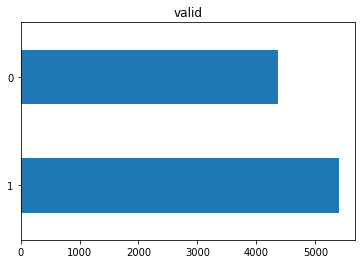

In [ ]:
(df_valid.gender.value_counts()).plot.barh()
plt.title("valid");

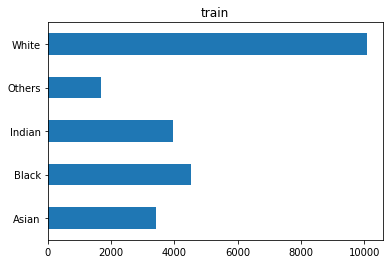

In [ ]:
d = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}
df_train.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("train");

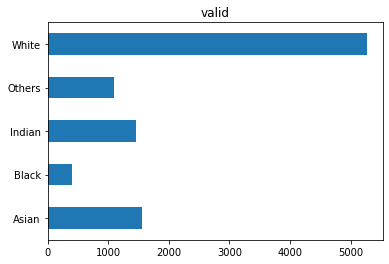

In [ ]:
df_valid.ethnicity.replace(d).value_counts().sort_index().plot.barh()
plt.title("valid");

# 2. Creating the Datasets, Dataloaders and Databunch

In [ ]:
class MultiTaskDataset(Dataset):
    def __init__(self,df, tfms, size=64):
        self.paths = list(df.name)
        self.labels = list(df.label)
        self.tfms = tfms
        self.size = size
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats

    def __len__(self): return len(self.paths)

    def __getitem__(self,idx):
        #dealing with the image
        img = PIL.Image.open(self.paths[idx]).convert('RGB')
        img = Image(pil2tensor(img, dtype=np.float32).div_(255))
        img = img.apply_tfms(self.tfms, size = self.size)
        img = self.norm(img.data)

        #dealing with the labels
        labels = self.labels[idx].split(" ")
        age = torch.tensor(float(labels[0]), dtype=torch.float32)
        gender = torch.tensor(int(labels[1]), dtype=torch.int64)
        ethnicity = torch.tensor(int(labels[2]), dtype=torch.int64)
        
        return img.data, (age.log_()/4.75, gender, ethnicity)

    def show(self,idx):
        x,y = self.__getitem__(idx)
        age,gender,ethnicity = y
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        img = ((x.numpy().transpose((1,2,0))*stds + means)*255).astype(np.uint8)
        plt.imshow(img)
        plt.title("{} {} {}".format(int(age.mul_(4.75).exp_().item()), gender.item(), ethnicity.item()))

In [ ]:
tfms = get_transforms()
train_ds = MultiTaskDataset(df_train, tfms[0], size=64)
valid_ds = MultiTaskDataset(df_valid, tfms[1], size=64)
train_dl = DataLoader(train_ds, batch_size=512, shuffle=True, num_workers=2)
valid_dl = DataLoader(valid_ds, batch_size=512, shuffle=True, num_workers=2)
data = DataBunch(train_dl, valid_dl)

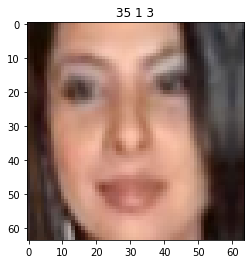

In [ ]:
train_ds.show(0)

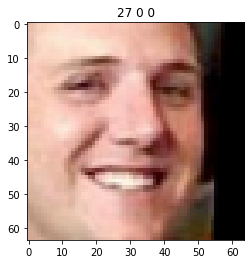

In [ ]:
valid_ds.show(0)

In [ ]:
class MultiTaskModel(nn.Module):
    def __init__(self, arch,ps=0.5):
        super(MultiTaskModel,self).__init__()
        self.encoder = create_body(arch)
        self.fc1 = create_head(1024,1,ps=ps)
        self.fc2 = create_head(1024,2,ps=ps)
        self.fc3 = create_head(1024,5,ps=ps)

    def forward(self,x):

        x = self.encoder(x)
        age = torch.sigmoid(self.fc1(x))
        gender = self.fc2(x)
        ethnicity = self.fc3(x)

        return [age, gender, ethnicity]

In [ ]:
class MultiTaskLossWrapper(nn.Module):
    def __init__(self, task_num):
        super(MultiTaskLossWrapper, self).__init__()
        self.task_num = task_num
        self.log_vars = nn.Parameter(torch.zeros((task_num)))

    def forward(self, preds, age, gender, ethnicity):

        mse, crossEntropy = MSELossFlat(), CrossEntropyFlat()
        
        sages = (age*4.75).exp_()
        idx1 = (sages <20) | ((sages > 40) & (sages <= 60))
        idx2 = sages > 60
        loss0 = mse(preds[0], age) + 2*mse(preds[0][idx1],age[idx1]) + 3*mse(preds[0][idx2],age[idx2]) #trying to account for the imbalance
        loss1 = crossEntropy(preds[1],gender)
        loss2 = crossEntropy(preds[2],ethnicity)

        precision0 = torch.exp(-self.log_vars[0])
        loss0 = precision0*loss0 + self.log_vars[0]

        precision1 = torch.exp(-self.log_vars[1])
        loss1 = precision1*loss1 + self.log_vars[1]

        precision2 = torch.exp(-self.log_vars[2])
        loss2 = precision2*loss2 + self.log_vars[2]
        
        return loss0+loss1+loss2

# 4. Defining Metrics, Learner and Training

In [ ]:
def rmse_age(preds, age, gender, ethnicity): return root_mean_squared_error(preds[0],age)
def acc_gender(preds, age, gender, ethnicity): return accuracy(preds[1], gender)
def acc_ethnicity(preds, age, gender, ethnicity): return accuracy(preds[2], ethnicity)
metrics = [rmse_age, acc_gender, acc_ethnicity]

In [ ]:
model = MultiTaskModel(models.resnet34, ps=0.25)

loss_func = MultiTaskLossWrapper(3).to(data.device) #just making sure the loss is on the gpu

learn = Learner(data, model, loss_func=loss_func, callback_fns=ShowGraph, metrics=metrics)

#spliting the model so that I can use discriminative learning rates
learn.split([learn.model.encoder[:6],
             learn.model.encoder[6:],
             nn.ModuleList([learn.model.fc1, learn.model.fc2, learn.model.fc3])]);

#first I'll train only the last layer group (the heads)
learn.freeze()

In [ ]:
torch.cuda.get_device_name()

'Tesla T4'

In [ ]:
torch.cuda.get_device_properties(0)

_CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15079MB, multi_processor_count=40)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


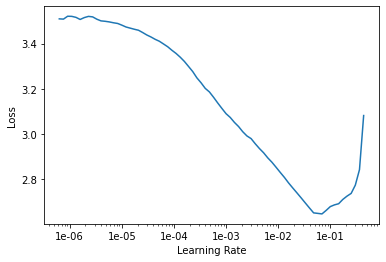

In [ ]:
learn.lr_find()
learn.recorder.plot()

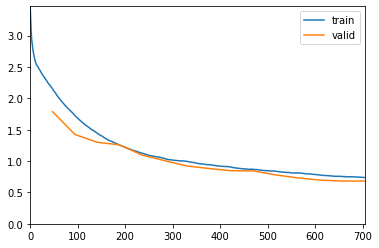

Better model found at epoch 0 with valid_loss value: 1.7877455949783325.
Better model found at epoch 1 with valid_loss value: 1.424150824546814.
Better model found at epoch 2 with valid_loss value: 1.2993577718734741.
Better model found at epoch 3 with valid_loss value: 1.258439540863037.
Better model found at epoch 4 with valid_loss value: 1.0966992378234863.
Better model found at epoch 5 with valid_loss value: 1.008690357208252.
Better model found at epoch 6 with valid_loss value: 0.9227629899978638.
Better model found at epoch 7 with valid_loss value: 0.88124680519104.
Better model found at epoch 8 with valid_loss value: 0.8460281491279602.
Better model found at epoch 9 with valid_loss value: 0.8435753583908081.
Better model found at epoch 10 with valid_loss value: 0.7786056399345398.
Better model found at epoch 11 with valid_loss value: 0.7312471866607666.
Better model found at epoch 12 with valid_loss value: 0.6954948306083679.
Better model found at epoch 13 with valid_loss value:

In [ ]:
learn.fit_one_cycle(15,max_lr=1e-2,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')])

In [ ]:
learn.load("stage-1");

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


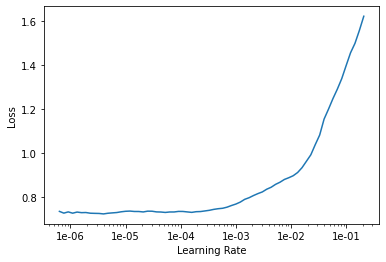

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

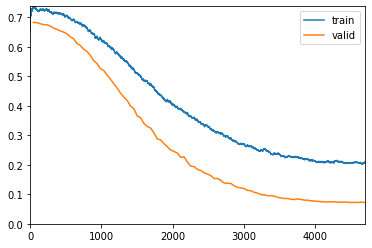

Better model found at epoch 0 with valid_loss value: 0.6835767030715942.
Better model found at epoch 1 with valid_loss value: 0.6823711395263672.
Better model found at epoch 2 with valid_loss value: 0.6788195371627808.
Better model found at epoch 3 with valid_loss value: 0.6757219433784485.
Better model found at epoch 4 with valid_loss value: 0.6754902005195618.
Better model found at epoch 5 with valid_loss value: 0.6709514856338501.
Better model found at epoch 6 with valid_loss value: 0.6642066240310669.
Better model found at epoch 7 with valid_loss value: 0.6598374247550964.
Better model found at epoch 8 with valid_loss value: 0.654427707195282.
Better model found at epoch 9 with valid_loss value: 0.6504475474357605.
Better model found at epoch 10 with valid_loss value: 0.6447869539260864.
Better model found at epoch 11 with valid_loss value: 0.6346135139465332.
Better model found at epoch 12 with valid_loss value: 0.6275506019592285.
Better model found at epoch 13 with valid_loss va

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(100,max_lr=slice(1e-6,3e-4),
                   callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

In [ ]:
learn = learn.load("stage-2")


# 5. Using the model to inference

In [ ]:
trained_model = learn.model.cpu()
torch.save(trained_model.state_dict(),"model_params_resnet34")

In [ ]:
class AgenethPredictor():
    def __init__(self, model):
        self.model = model
        self.tfms = get_transforms()[1]
        self.norm = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #imagenet stats
        self.gender = {0:"Male",1:"Female"}
        self.ethnicity = {0:"White",1:"Black",2:"Asian",3:"Indian",4:"Others"}

    def predict(self,x):
        #x is a PIL Image
        x = Image(pil2tensor(x, dtype=np.float32).div_(255))
        x = x.apply_tfms(self.tfms, size = 64)
        x = self.norm(x.data)
        preds = self.model(x.unsqueeze(0))
        age = int(torch.exp(preds[0]*4.75).item())
        gender = self.gender[torch.softmax(preds[1],1).argmax().item()]
        ethnicity = self.ethnicity[torch.softmax(preds[2],1).argmax().item()]
        return age, gender, ethnicity

In [ ]:
ageneth_predictor = AgenethPredictor(trained_model)

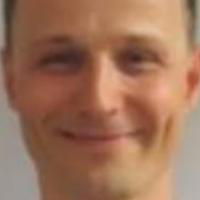

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[100])
img

In [ ]:
df_valid.name.iloc[100]

'utkface_aligned_cropped/crop_part1/37_0_0_20170104205628245.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 54.6 ms, sys: 10.9 ms, total: 65.5 ms
Wall time: 156 ms


(45, 'Male', 'White')

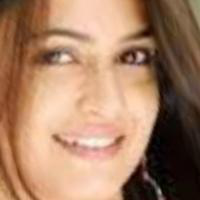

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[1000])
img

In [ ]:
df_valid.name.iloc[1000]

'utkface_aligned_cropped/crop_part1/23_1_3_20170104223058543.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 50.7 ms, sys: 0 ns, total: 50.7 ms
Wall time: 55.5 ms


(23, 'Female', 'Indian')

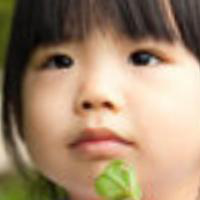

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[2000])
img

In [ ]:
df_valid.name.iloc[2000]

'utkface_aligned_cropped/crop_part1/4_1_2_20161219163346526.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 42 ms, sys: 0 ns, total: 42 ms
Wall time: 43.4 ms


(3, 'Female', 'Asian')

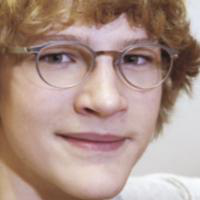

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[50])
img

In [ ]:
df_valid.name.iloc[50]

'utkface_aligned_cropped/crop_part1/16_0_0_20170110232111509.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 43 ms, sys: 0 ns, total: 43 ms
Wall time: 43.5 ms


(18, 'Male', 'White')

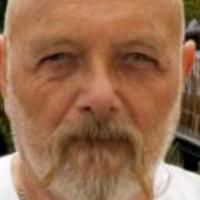

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[9000])
img

In [ ]:
df_valid.name.iloc[9000]

'utkface_aligned_cropped/crop_part1/65_0_0_20170111200004259.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 41.3 ms, sys: 692 µs, total: 41.9 ms
Wall time: 44.7 ms


(64, 'Male', 'White')

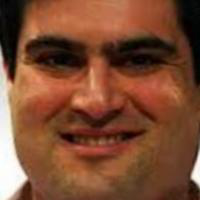

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-1])
img

In [ ]:
df_valid.name.iloc[-1]

'utkface_aligned_cropped/crop_part1/34_0_4_20170105165000683.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 53.5 ms, sys: 2.43 ms, total: 55.9 ms
Wall time: 59.2 ms


(38, 'Male', 'Others')

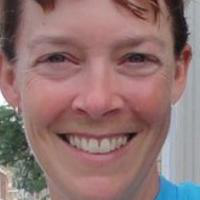

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-100])
img

In [ ]:
df_valid.name.iloc[-100]

'utkface_aligned_cropped/crop_part1/53_1_0_20170110144754148.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 43.3 ms, sys: 1.74 ms, total: 45 ms
Wall time: 45.3 ms


(25, 'Female', 'White')

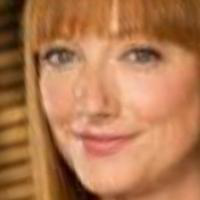

In [ ]:
img = PIL.Image.open(df_valid.name.iloc[-500])
img

In [ ]:
df_valid.name.iloc[-500]

'utkface_aligned_cropped/crop_part1/26_1_0_20170103180946896.jpg.chip.jpg'

In [ ]:
%time ageneth_predictor.predict(img)

CPU times: user 40.6 ms, sys: 309 µs, total: 40.9 ms
Wall time: 45.1 ms


(47, 'Female', 'White')

* A more advanced example: Multi-task Deep Learning Experiment using fastai Pytorch

This notebook is a line-by-line example of a multi-task deep learning model, implemented using the *fastai* v1 library for PyTorch. This model takes in an image of a human face and predicts their gender, race, and age. 

This notebook wants to show:
1. an example of a multi-task deep learning model;
2. the multi-task model makes better predictions than the individual model; and
2. how to use the fastai library to easily implement the model.

This document is written in a working Jupyter notebook, so you can run and change the code if you like (at least it's fun to randomly sample faces - some of them are famous).

## An excellent example/tutorial on Multi-task learning
Borrowed form: [Yang Zhang](https://gist.github.com/yang-zhang)

* https://gist.github.com/yang-zhang/ec071ae4775c2125595fd80f40efb0d6

* https://medium.com/@zhang_yang/multi-task-deep-learning-experiment-using-fastai-pytorch-2b5e9d078069

First, some quick introduction to multi-task learning.

### What it is 

> [wikipedia](https://en.wikipedia.org/wiki/Multi-task_learning): Multi-task learning (MTL) is a subfield of machine learning in which *multiple learning tasks are solved at the same time*, while exploiting commonalities and differences across tasks. 

    In this notebook, *multiple learning tasks* are the three tasks to predict gender, race (both classification tasks), and age (a regression task), respectively.

### Why do it
> [wikipedia](https://en.wikipedia.org/wiki/Multi-task_learning): This can result in *improved learning efficiency and prediction accuracy* for the task-specific models, when compared to training the models separately.

    In this notebook,
    - Regarding *improved learning efficiency*: we run the multi-task model once instead of three time for the single-task models (all four models have similar run time). 
    - Regarding *improved prediction accuracy*: we will show that the multi-task model cut average age prediction error in half from 10 years to 5 years while holding the gender and race prediction accuracy almost the same. 

### Why it works  
> [wikipedia](https://en.wikipedia.org/wiki/Multi-task_learning): Multi-task learning works because *regularization induced by requiring an algorithm to perform well on a related task* can be superior to regularization that prevents overfitting by penalizing all complexity uniformly. 
    
    We will not cover the math here. Wikipedia provides some good resources. 

## fastai

We use the library [fastai v1 for PyTorch](https://www.fast.ai/2018/10/02/fastai-ai/) to implement our model. This software is built by the organization also called [fastai](https://www.fast.ai/) and founded by Jeremy Howard and Rachel Thomas to "make neural nets uncool again". Its free on-line deep learning courses are considered by many researchers the best out there. The fastai software library "simplifies training fast and accurate neural nets using modern best practices", in other words, it's really easy to use and it works really well.

##  The data and the problem

We use [UTKFace](http://aicip.eecs.utk.edu/wiki/UTKFace) data for this experiment.
> UTKFace dataset is a large-scale face dataset with long age span (range from 0 to 116 years old). The dataset consists of over 20,000 face images with annotations of age, gender, and ethnicity. The images cover large variation in pose, facial expression, illumination, occlusion, resolution, etc. This dataset could be used on a variety of tasks, e.g., face detection, age estimation, age progression/regression, landmark localization, etc. 

We will try to predict gender, race (both classification tasks), and age (a regression task), respectively, based on the image. In the setting of multi-task learning, we could think of age as the central task partly because it is more difficult. 

Imports

In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from pathlib import Path

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from fastai import *
from fastai.vision import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


We can see fastai v1 is being used:

In [ ]:
import fastai; fastai.__version__

'1.0.19'

`pathlib` is a good package to deal with file paths.

In [ ]:
Path

pathlib.Path

Create these `Path` objects so that 
- `pdata`: path to dataset
- `p`: path to project folder

In [ ]:
pdata = Path('/data/utkface/')
p = Path('.')

We will use the 23k cropped faces.

In [ ]:
fns = list(pdata.glob('UTKface_Aligned_cropped/UTKFace/*.jpg'))
len(fns)

23708

The labels of each face image is embedded in the file name, formatted like `[age]_[gender]_[race]_[date&time].jpg`

`[age]` is an integer from 0 to 116, indicating the age
`[gender]` is either 0 (male) or 1 (female)
`[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).
`[date&time]` is in the format of yyyymmddHHMMSSFFF, showing the date and time an image was collected to UTKFace

In [ ]:
fns[:3]

[PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/35_1_0_20170117183059886.jpg.chip.jpg'),
 PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/30_0_0_20170117130638578.jpg.chip.jpg'),
 PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/18_1_0_20170109214453184.jpg.chip.jpg')]

Remove files with bad-format names (only a few).

In [ ]:
fns = [fn for fn in fns if len(str(fn).split('/')[-1].split('_'))==4 and '__' not in str(fn)]
len(fns)

23705

A handy function to look at the content of a dictionary. 

In [ ]:
def show_dct(dct, n=3):
    return dict(list(dct.items())[:n])

Create these look-up maps
- `i2fn`: image index to filename
- `fn2i`: filename to index

In [ ]:
i2fn = fns
fn2i = {fn:i for i,fn in enumerate(i2fn)}
show_dct(fn2i)

{PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/35_1_0_20170117183059886.jpg.chip.jpg'): 0,
 PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/30_0_0_20170117130638578.jpg.chip.jpg'): 1,
 PosixPath('/data/utkface/UTKface_Aligned_cropped/UTKFace/18_1_0_20170109214453184.jpg.chip.jpg'): 2}

The labels of each face image is embedded in the file name, formated like `[age]_[gender]_[race]_[date&time].jpg`

In [ ]:
bs_fns = [os.path.basename(o) for o in fns]
bs_fns[:3]

['35_1_0_20170117183059886.jpg.chip.jpg',
 '30_0_0_20170117130638578.jpg.chip.jpg',
 '18_1_0_20170109214453184.jpg.chip.jpg']

Create these look-up maps

- `i2age`: image index to age
- `i2gender`: image index to gender
- `i2race`: image index to race

In [ ]:
i2age, i2gender, i2race = zip(*[bs_fn.split('_')[:3] for bs_fn in bs_fns])

`[age]` is an integer from 0 to 116, indicating the age

In [ ]:
i2age = [int(o) for o in i2age]
i2age[:3]

[35, 30, 18]

`[gender]` is either 0 (male) or 1 (female)

In [ ]:
o2gender = {'0': 'm', '1': 'f'}
i2gender = [o2gender[o] for o in i2gender]

i2gender[:3]

['f', 'm', 'f']

`[race]` is an integer from 0 to 4, denoting White, Black, Asian, Indian, and Others (like Hispanic, Latino, Middle Eastern).

In [ ]:
o2race = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
i2race = [o2race[int(o)] for o in i2race]
i2race[:3]

['White', 'White', 'White']

## Explore data

In [ ]:
Some sanity check on the data.

Gender counts. Seems even.

In [ ]:
Counter(i2gender)

Counter({'f': 11314, 'm': 12391})

Race counts. Notice this might not be the same race distribution as the data in your own problem. 

In [ ]:
Counter(i2race).most_common()

[('White', 10078),
 ('Black', 4526),
 ('Indian', 3975),
 ('Asian', 3434),
 ('Others', 1692)]

Gender per race counts. Seems relatively even.

In [ ]:
sorted(Counter(list(zip(i2race, i2gender))). items())

[(('Asian', 'f'), 1859),
 (('Asian', 'm'), 1575),
 (('Black', 'f'), 2208),
 (('Black', 'm'), 2318),
 (('Indian', 'f'), 1714),
 (('Indian', 'm'), 2261),
 (('Others', 'f'), 932),
 (('Others', 'm'), 760),
 (('White', 'f'), 4601),
 (('White', 'm'), 5477)]

Let's look at the distribution of age. Looks like babies and 20-year olds like their pictures taken the most.

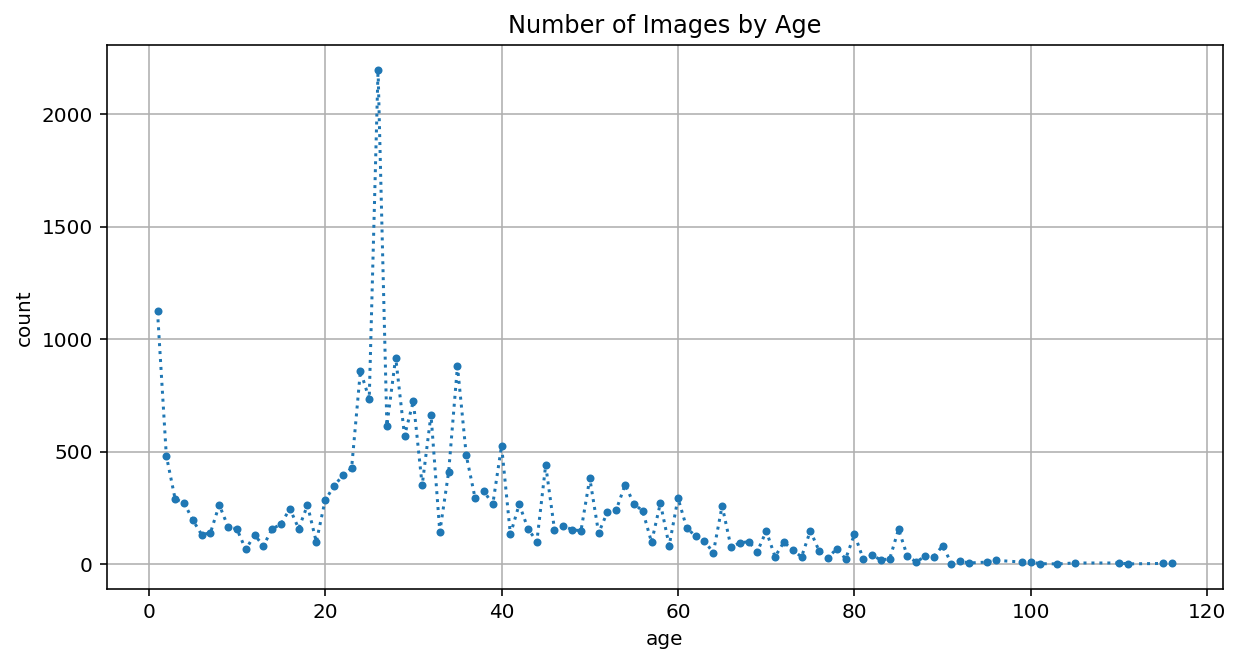

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(*zip(*sorted(Counter(i2age).items())), '.:')
plt.title('Number of Images by Age')
plt.ylabel('count')
plt.xlabel('age')
plt.grid()

Distribution of age per gender. Nothing strange.

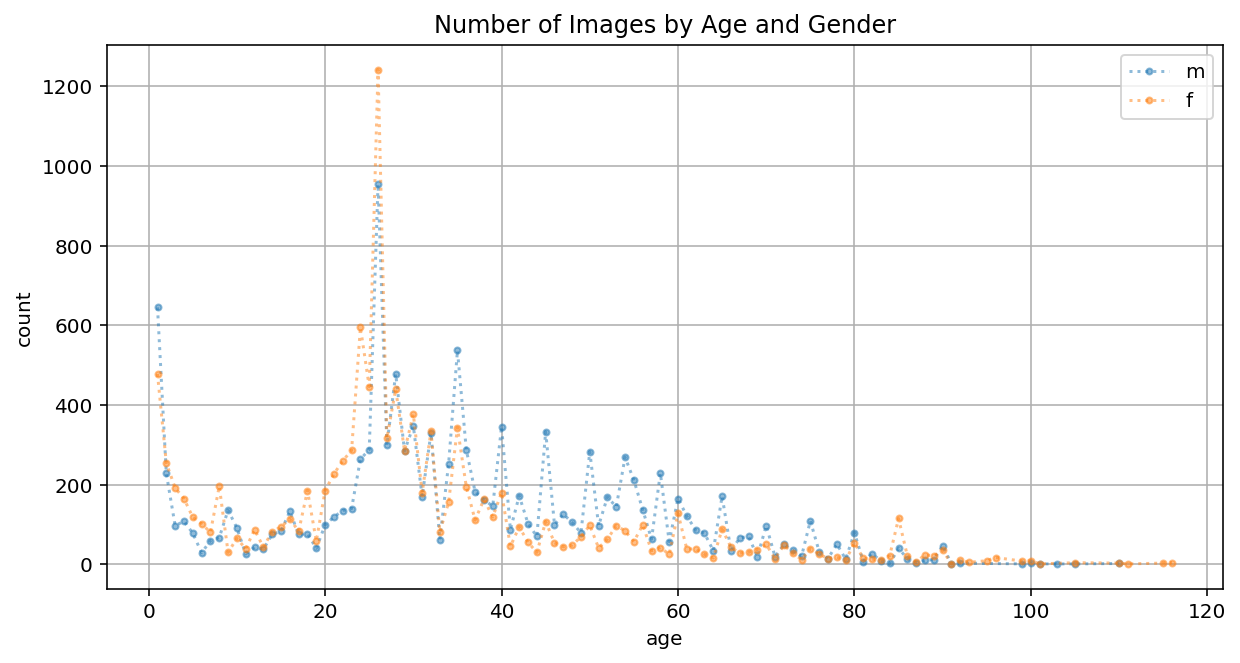

In [ ]:
plt.figure(figsize=(10, 5))
for gender in o2gender.values():
    ages_gender=[age for i, age in enumerate(i2age) if i2gender[i]==gender]
    plt.plot(*zip(*sorted(Counter(ages_gender).items())), '.:', label=gender, alpha=.5)
    plt.title('Number of Images by Age and Gender')
    plt.ylabel('count')
    plt.xlabel('age')
    plt.legend()
plt.grid()

Distribution of age per race. Nothing strange.

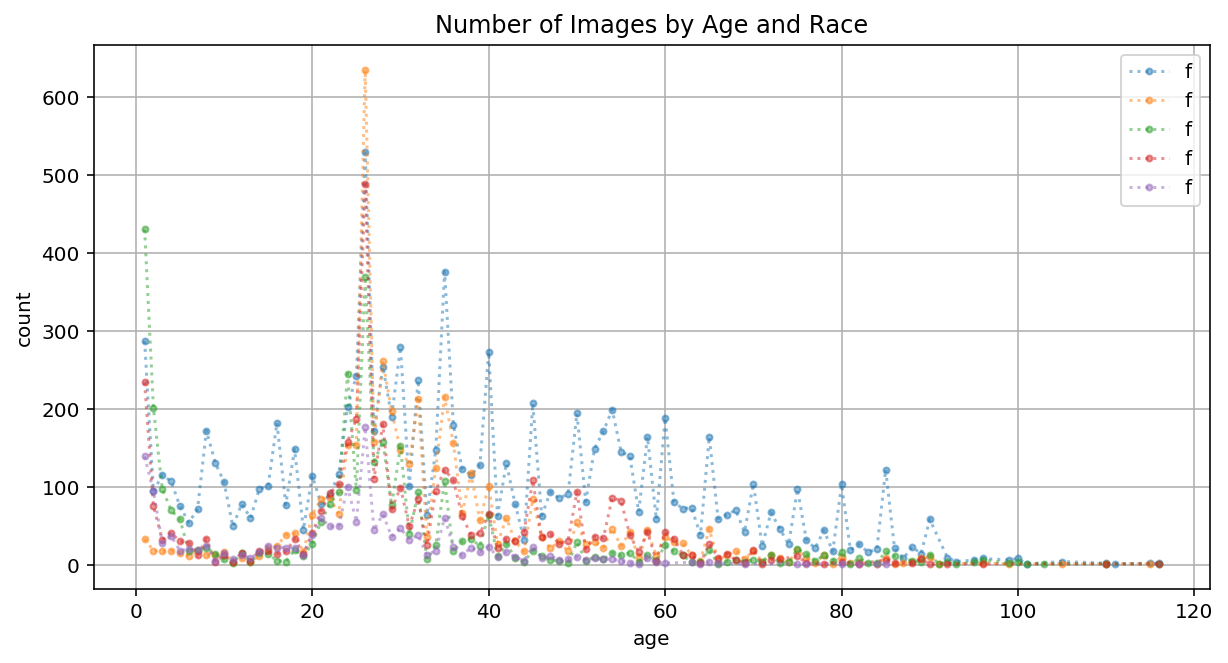

In [ ]:
plt.figure(figsize=(10, 5))

for race in o2race.values():
    ages_race=[age for i, age in enumerate(i2age) if i2race[i]==race]
    plt.plot(*zip(*sorted(Counter(ages_race).items())), '.:', label=gender, alpha=.5)
    plt.title('Number of Images by Age and Race')
    plt.ylabel('count')
    plt.xlabel('age')
    plt.legend()
plt.grid()


Let's look at some pictures for sanity check.

Random picture. Notice that `open_image` is a fastai function that returns a fastai `Image` object.

age: 32; gender: m; race: White


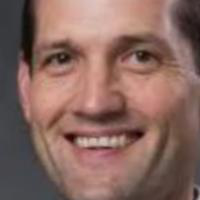

In [ ]:
fn = np.random.choice(fns)
i = fn2i[fn]
print(f'age: {i2age[i]}; gender: {i2gender[i]}; race: {i2race[i]}')
open_image(fn)

A grid of random pictures. Using fastai `show_image` function it's easy to arrange the images by the `axs`.

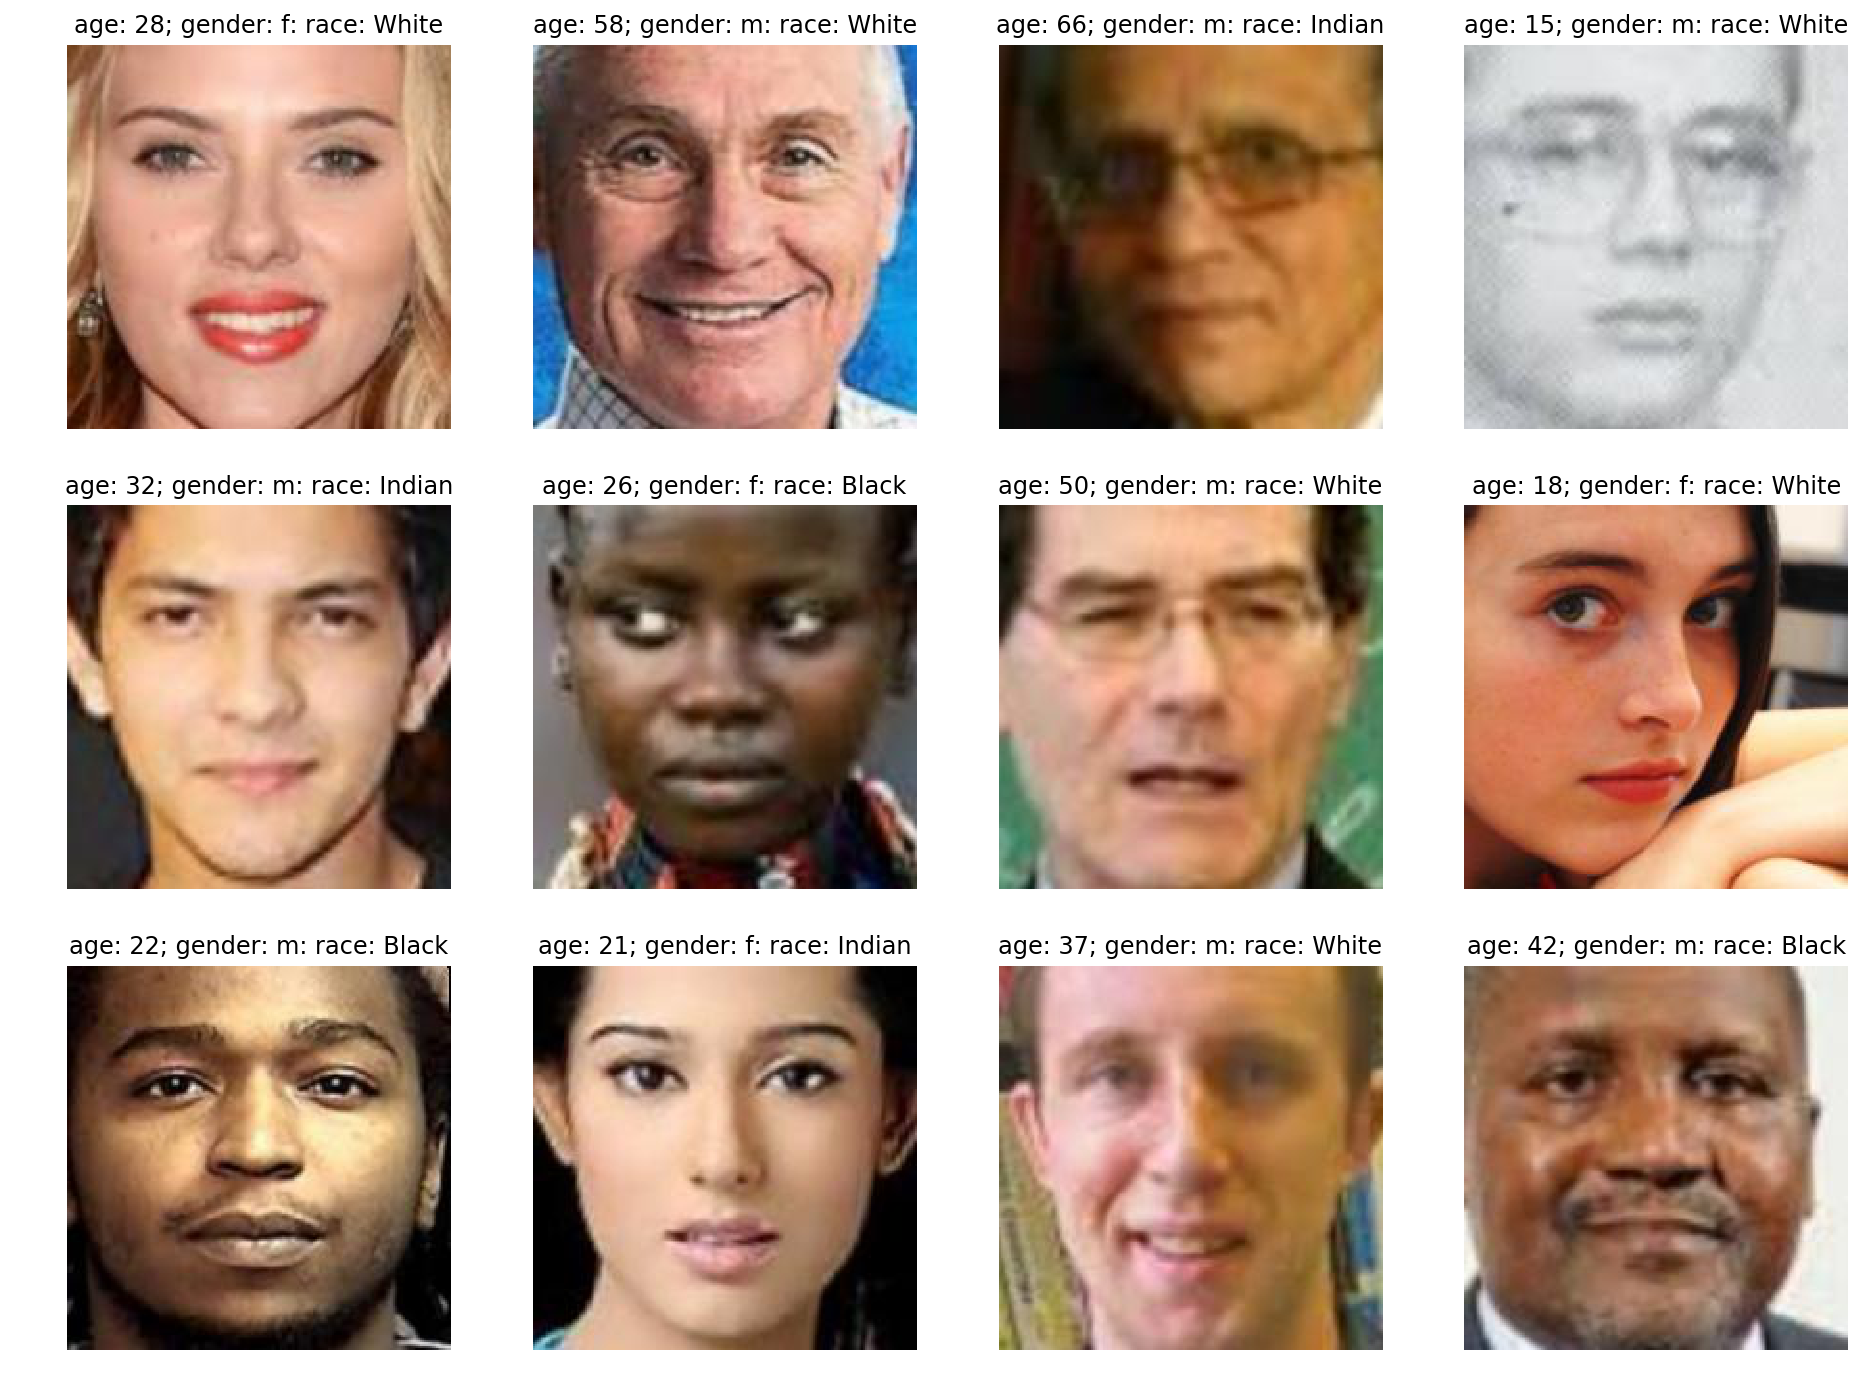

In [ ]:
nr, nc = 3, 4
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(4*nc, 4*nr))
fns_sample = np.random.choice(fns, nr*nc)

for j, fn in enumerate(fns_sample):
    i = fn2i[fn]
    show_image(open_image(fn), axs[j//nc, j%nc])
    axs[j//nc, j%nc].set(title=f'age: {i2age[i]}; gender: {i2gender[i]}: race: {i2race[i]}')

## Process data for modeling

Combine the above maps into a pandas data frame.

In [ ]:
df = pd.DataFrame({'img_name': i2fn, 'age': i2age, 'gender': i2gender, 'race': i2race})

df.shape

(23705, 4)

Random sampling 80% training and 20% validation. Note that we only do this once so we use the same split for the three single-task and one multi-task models.

In [ ]:
df['is_train'] = np.random.choice(2, size=len(df), p=[0.2, 0.8])

In [ ]:
df.head()

img_name  age gender   race  \
0  /data/utkface/UTKface_Aligned_cropped/UTKFace/...   35      f  White   
1  /data/utkface/UTKface_Aligned_cropped/UTKFace/...   30      m  White   
2  /data/utkface/UTKface_Aligned_cropped/UTKFace/...   18      f  White   
3  /data/utkface/UTKface_Aligned_cropped/UTKFace/...   26      f  White   
4  /data/utkface/UTKface_Aligned_cropped/UTKFace/...   36      f  White   

   is_train  
0         1  
1         0  
2         1  
3         1  
4         1

Save the data frame. 

In [ ]:
df.to_csv('img2targets.csv', index=False)

Sanity check again by look at random pictures.

age: 67, gender: m, race: Indian


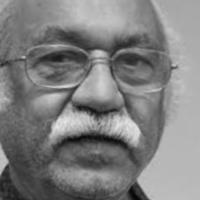

In [ ]:
i = np.random.choice(len(df))
dfi = df.iloc[i]

print(f'age: {dfi["age"]}, gender: {dfi["gender"]}, race: {dfi["race"]}')
open_image(dfi["img_name"])

## Single-task models

For comparison, we will first build single-task models for the three tasks: gender, race, and age predictions. We will build the multi-task model in the next section.

### gender model

In [ ]:
target = 'gender'

The code below creates two fastai `ImageClassificationDataset` objects, one for training and one for validation. The `ImageClassificationDataset` takes in the image names and the target (`gender`) variable. The train/validation split is based on the `is_train` column.

In [ ]:
df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_train'])

classes = sorted(set(df[target]))

def get_dataset(df, classes=None):
    return ImageClassificationDataset(df.img_name, df[target], classes)

train_ds = get_dataset(df[df.is_train==1], classes)
valid_ds = get_dataset(df[df.is_train==0], classes)

The training and validation data sets are then combined to create a fastai `ImageDataBunch` object, which takes care of making images (`sz` being image size)and target variables into batches (`bs` being batch size), as well as transformations for image augmentation (from `get_transforms()`) and normalization (by `normalize(imagenet_stats)`) by imagenet mean and standard deviation. 


In [ ]:
def get_data(sz, bs):
    return ImageDataBunch.create(train_ds, valid_ds, path=p, bs=bs, size=sz,
                            ds_tfms=get_transforms()).normalize(imagenet_stats)

data = get_data(sz=200, bs=128)

We can take a look at a random image and lable from the dataset. 

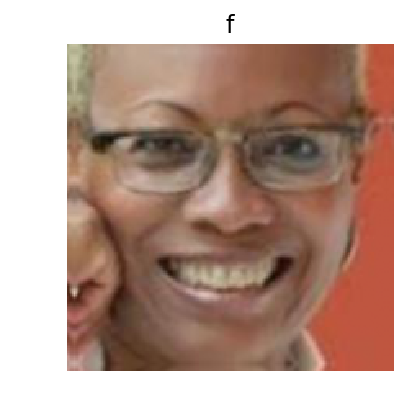

In [ ]:
i = np.random.choice(len(data.valid_ds))
img,label = data.valid_ds[i]
img.show(title=classes[label])

In one line of code, `create_cnn` function will create a `ClassificationLearner` object from the data and the pretrained model, here we use `resnet50`. 

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

In [ ]:
type(learn)

fastai.vision.learner.ClassificationLearner

The library will determine the proper loss function (in this case `cross_entropy`) based on the data.

In [ ]:
learn.loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean')>

The output is 2-dimension (`out_features=2`), corresponding to the two classes 'f' and 'm'.

In [ ]:
list(learn.model.children())[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

We now use fastai learning rate finder to find the proper learning rate, a technique presented in Leslie Smith's paper [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186).

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


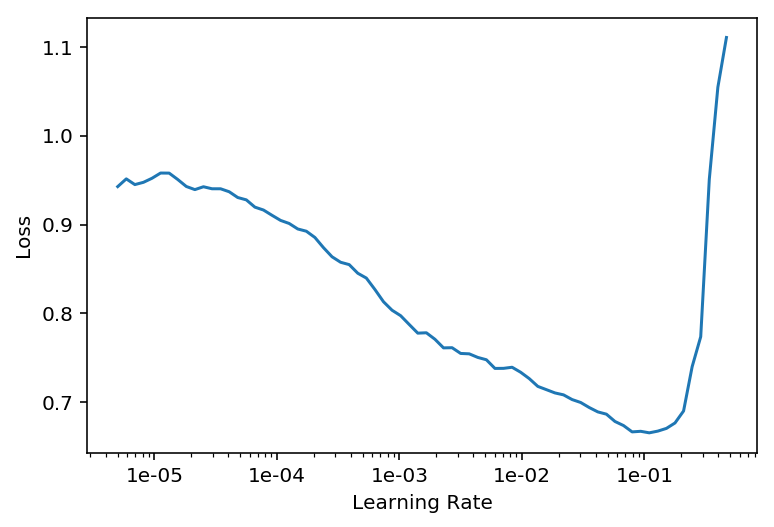

In [ ]:
learn.lr_find(start_lr=1e-6)
learn.recorder.plot()

We select a learning rate a couple of magnitudes smaller than the one corresponding to the turning point of the loss function.

In [ ]:
lr=1e-3

We can now take advantage of 1cycle training, an advanced learning strategy created in Leslie Smith's [paper](https://arxiv.org/abs/1803.09820), using fastai `fit_one_cycle` function. A good article that introduces this topic is [here](https://sgugger.github.io/the-1cycle-policy.html).


We first `freeze` the model to train the last linear layer and then `unfreeze` the bottom layers to fine tune the model.


In [ ]:
def train_model(sz, bs, lr):
    learn.data=get_data(sz, bs)
    learn.freeze()
    learn.fit_one_cycle(5, slice(lr))
    learn.unfreeze()
    learn.fit_one_cycle(5, slice(lr/20, lr/2), pct_start=0.1)
    learn.save(f"{target}")

We see a validation accuracy of 94%. 

In [ ]:
train_model(sz, bs, lr)

Total time: 04:57
epoch  train_loss  valid_loss  accuracy
1      0.235934    0.204241    0.914238  (01:00)
2      0.192769    0.215256    0.911324  (00:59)
3      0.152971    0.159835    0.939425  (00:59)
4      0.121540    0.157800    0.942340  (00:58)
5      0.091842    0.157737    0.940258  (00:59)



### race model 

Now on to the model for race. This is the only line different from the gender model.

In [ ]:
target = 'race'

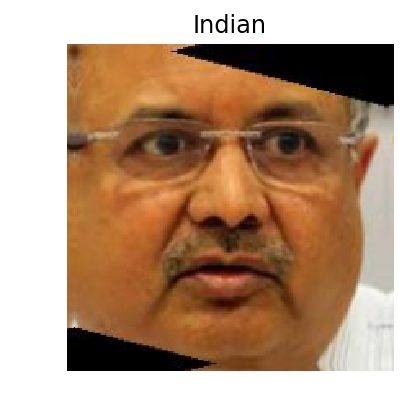

In [ ]:
df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_train'])

classes = sorted(set(df[target]))

def get_dataset(df, classes=None):
    return ImageClassificationDataset(df.img_name, df[target], classes)

train_ds = get_dataset(df[df.is_train==1], classes)
valid_ds = get_dataset(df[df.is_train==0], classes)

def get_data(sz, bs):
    return ImageDataBunch.create(train_ds, valid_ds, path=p, bs=bs, size=sz,
                            ds_tfms=get_transforms()).normalize(imagenet_stats)

data = get_data(sz=200, bs=128)

i = np.random.choice(len(data.valid_ds))
img,label = data.valid_ds[i]

# img.show(title=" ".join(np.array(data.classes)[np.where(labels)[0]]))
img.show(title=classes[label])

In [ ]:
learn = create_cnn(data, models.resnet50, metrics=accuracy)

Notice now the output is 5-dimension (`out_features=5`) corresponding to the 5 races.

In [ ]:
list(learn.model.children())[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=5, bias=True)
)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


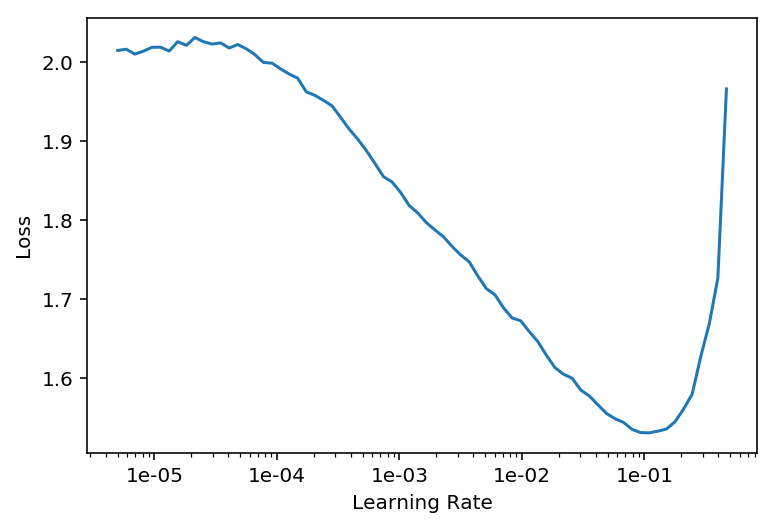

In [ ]:
learn.lr_find(start_lr=1e-6)
learn.recorder.plot()

In [ ]:
lr=1e-3

We see a validation accuracy of 86%. 

In [ ]:
train_model(sz, bs, lr)

Total time: 04:54
epoch  train_loss  valid_loss  accuracy
1      0.638160    0.615333    0.793714  (00:58)
2      0.509656    0.485606    0.837843  (00:58)
3      0.411160    0.446441    0.849917  (00:58)
4      0.322892    0.423798    0.864072  (00:58)
5      0.268390    0.423851    0.867194  (00:59)



### age model

In [ ]:
target = 'age'

df = pd.read_csv('img2targets.csv', usecols=['img_name', target, 'is_train'])

The age prediction task is a regression problem. As the writing of this notebook, fastai does yet not have an `ImageRegressionDataset` class. (It's a fast growing library and might have one soon). So we will adapt `ImageClassificationDataset` a little bit into a regression dataset, by
1. setting `y` to be the value of the target variable (after adding a batch dimension by `[:, None]`;
2. setting `c=1`, so that the output of the network will be 1-dimension; and
3. setting `loss_func = F.l1_loss` for the regression problem.

As we can see it's not hard to change how the library currently works to adapt to your problem.

In [ ]:
def get_dataset(df):
    ds = ImageClassificationDataset(df.img_name, df[target])
    ds.y = df[target].values[:, None].astype('float32')
    ds.c = 1
    ds.loss_func = F.l1_loss
    return ds

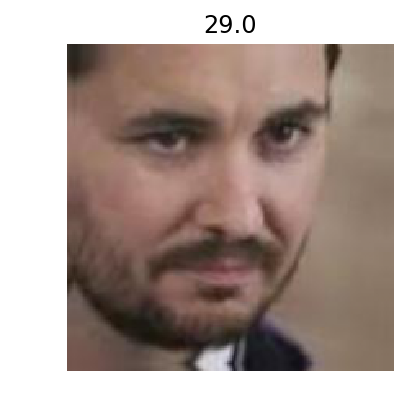

In [ ]:
train_ds = get_dataset(df[df.is_train==1])
valid_ds = get_dataset(df[df.is_train==0])

def get_data(sz, bs):
    return ImageDataBunch.create(train_ds, valid_ds, path=p, bs=bs, size=sz,
                            ds_tfms=get_transforms()).normalize(imagenet_stats)

data = get_data(sz=200, bs=128)

i = np.random.choice(len(data.valid_ds))
img,y = data.valid_ds[i]

img.show(title=y[0])

In [ ]:
learn = create_cnn(data, models.resnet50)

Notice now the output is 1-dimension (`out_features=1`).

In [ ]:
list(learn.model.children())[-1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=4096, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=1, bias=True)
)

We can verify the loss function

In [ ]:
learn.loss_func

<function torch.nn.functional.l1_loss(input, target, size_average=None, reduce=None, reduction='elementwise_mean')>

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


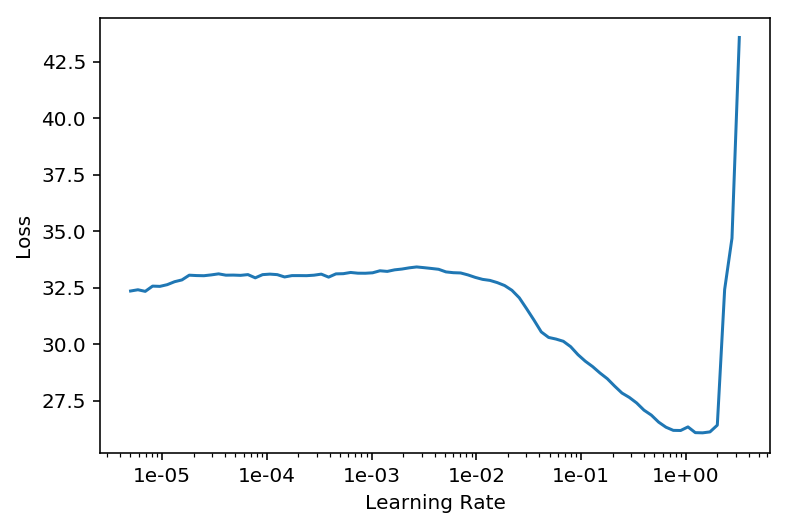

In [ ]:
learn.lr_find(start_lr=1e-6)
learn.recorder.plot()

In [ ]:
lr=1e-2

This gives us a 10-year average prediction error.

In [ ]:
train_model(sz, bs, lr)

Total time: 12:38
epoch  train_loss  valid_loss
1      14.204471   564.279358  (02:34)
2      12.710217   24.991791   (02:35)
3      11.125519   10.210242   (02:31)
4      11.082458   10.972696   (02:29)
5      9.949615    10.627416   (02:27)



This concludes the single-task models. We now combine the three problems together to make a multi-task model.

## Multi-task model

### dataset

We will create a custom dataset called `MultitaskDataset` as a subclass of pytorch's (not fastai) `Dataset`. The goal is for it to be compatible with fastai `ImageDataBunch` so we can continue to take advantage of fastai library's other methods.

In [ ]:
Dataset

torch.utils.data.dataset.Dataset

It draws inspiration from fastai `ImageClassificationDataset`.

In [ ]:
df = pd.read_csv('img2targets.csv')

class MultitaskDataset(Dataset):
    "`Dataset` for joint single and multi-label image classification."
    def __init__(self, 
                 fns,
                 labels_gender,
                 labels_race,
                 ages,
                 classes_race,
                 classes_gender):
        self.x = np.array(fns)
        
        self.classes_gender = classes_gender
        self.classes_race = classes_race

        self.class2idx_gender = {v:k for k,v in enumerate(self.classes_gender)}
        self.y_gender = np.array([self.class2idx_gender[o] for o in labels_gender], dtype=np.int64)

        self.class2idx_race = {v:k for k,v in enumerate(self.classes_race)}
        self.y_race = np.array([self.class2idx_race[o] for o in labels_race], dtype=np.int64)
        
        self.y_age = ages[:, None].astype('float32')
        
        self.c_gender = len(classes_gender)
        self.c_race = len(classes_race)
        self.c_age = 1

        self.c = self.c_gender + self.c_race + self.c_age

    
    def __len__(self): return len(self.x)
    
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray, np.ndarray]: 
        return open_image(self.x[i]), torch.tensor([self.y_gender[i], self.y_race[i], self.y_age[i]]).float()
    
    def __repr__(self): return f'{type(self).__name__} of len {len(self)}'

In [ ]:
def get_dataset(df):
    return MultitaskDataset(df.img_name, 
                            labels_gender=df.gender, 
                            labels_race=df.race,
                            ages=df.age,
                            classes_race=sorted(set(df.race)),
                            classes_gender=sorted(set(df.gender))
                           )

In [ ]:
train_ds = get_dataset(df[df.is_train==1])
valid_ds = get_dataset(df[df.is_train==0])

`x` component of the dataset if simply the image name.

In [ ]:
valid_ds.x[:3]

array(['/data/utkface/UTKface_Aligned_cropped/UTKFace/17_1_0_20170109205309078.jpg.chip.jpg',
       '/data/utkface/UTKface_Aligned_cropped/UTKFace/34_0_0_20170119200555732.jpg.chip.jpg',
       '/data/utkface/UTKface_Aligned_cropped/UTKFace/17_0_4_20170103234631508.jpg.chip.jpg'], dtype=object)

Target variables need more work. 
For the classification variables gender and race we define their classes (e.g. `classes_gender`) and class2idx lookup maps (e.g., `class2idx_gender`)

In [ ]:
valid_ds.classes_gender

['f', 'm']

In [ ]:
valid_ds.class2idx_gender

{'f': 0, 'm': 1}

We then tell the dataset what gender or race each image has

In [ ]:
valid_ds.y_gender[:3]

array([0, 1, 1])

age is simple, just a number for each image

In [ ]:
valid_ds.y_age[:3]

array([[17.],
       [34.],
       [17.]], dtype=float32)

We need to set the cardinalities of the variables `c_gender`, `c_race`, `c_age`, and their sum `c`, so that we can create model of the right output dimension. 

In [ ]:
valid_ds.c_gender, valid_ds.c_race, valid_ds.c_age, valid_ds.c

(2, 5, 1, 8)

Finally we need to set create the `__len__` and `__getitem__` methods which every pytorch `Dataset` must have. 

`__len__` simply returns the number of images in the dataset

In [ ]:
len(valid_ds)

4804

`__getitem__` returns a tuple. The first is the image tensor, the second is the three target varialbes.

In [ ]:
valid_ds[0][0].shape, valid_ds[0][1]

(torch.Size([3, 200, 200]), tensor([ 0.,  4., 17.]))

In [ ]:
def get_data(sz, bs):
    return ImageDataBunch.create(train_ds, valid_ds, path=p, bs=bs, size=sz,
                            ds_tfms=get_transforms()).normalize(imagenet_stats)

In [ ]:
data = get_data(sz=200, bs=8)

Again, sanity check by looking at random pictures and labels.

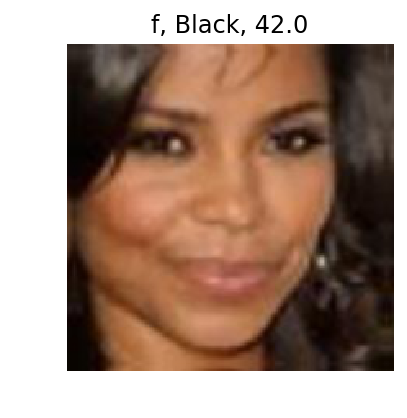

In [ ]:
img, (igender, irace, age) = data.valid_ds[np.random.choice(len(data.valid_ds))]
gender = data.valid_ds.classes_gender[int(igender)]
race = data.valid_ds.classes_race[int(irace)]
img.show(title= f"{gender}, {race}, {age}")

### model

Now to the model. We will need to combine the three loss functions into one. For this we create this `multitask_loss` function below.
It uses `c_gender`, `c_race`, `c_age` of the dataset object to locate the model outputs corresponding to the three tasks:

```
input_gender = input[:,:data.c_gender]
input_race = input[:,data.c_gender:data.c_gender+data.c_race]
input_age = input[:,-data.c_age:]
```

It then get the target variables (the ground truth):
```
target_gender, target_race, target_age = target[:,0], target[:, 1], target[:, 2]
```

and feed them to the proper loss functions (`cross_entropy` for classification and `l1_loss` for regression)
```
loss_gender = F.cross_entropy(input_gender, target_gender.long())
loss_race = F.cross_entropy(input_race, target_race.long())
loss_age = F.l1_loss(input_age, target_age.unsqueeze(1))

```

Finally, we scale the losses so that they are of similar magnitude. The scaling factors can be observed from the single-task model above. For example, age prediction loss was about 10.
```
return loss_gender/(.16) + loss_race/(.44) +  loss_age/10
```

In [ ]:
def multitask_loss(input, target):
    input_gender = input[:,:data.c_gender]
    input_race = input[:,data.c_gender:data.c_gender+data.c_race]
    input_age = input[:,-data.c_age:]
    target_gender, target_race, target_age = target[:,0], target[:, 1], target[:, 2]
    loss_gender = F.cross_entropy(input_gender, target_gender.long())
    loss_race = F.cross_entropy(input_race, target_race.long())
    loss_age = F.l1_loss(input_age, target_age.unsqueeze(1))
    return loss_gender/(.16) + loss_race/(.44) +  loss_age/10

For metrics, we again use `c_gender`, `c_race`, `c_age` of the dataset object to locate the model outputs corresponding to the three tasks and compute accuracy and l1_loss again the ground truth target.

In [ ]:
def accuracy_gender(input, targs):
    input_gender = input[:,:data.c_gender]
    target_gender = targs[:, 0].long()
    return accuracy(input_gender, target_gender)

def accuracy_race(input, targs):
    input_race = input[:,data.c_gender:data.c_gender+data.c_race]
    target_race = targs[:, 1].long()
    return accuracy(input_race, target_race)

def l1loss_age(input, targs):
    input_age = input[:,-data.c_age:]
    target_age = targs[:, 2].unsqueeze(1)
    return F.l1_loss(input_age, target_age).mean()

Now we simple pass the custom data, pretrained model, custom metrics and custom loss functions to `create_cnn` to get our model.

In [ ]:
learn = create_cnn(data, models.resnet50, 
                    metrics=[accuracy_gender,
                            accuracy_race,
                            l1loss_age],
                    loss_func=multitask_loss)

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


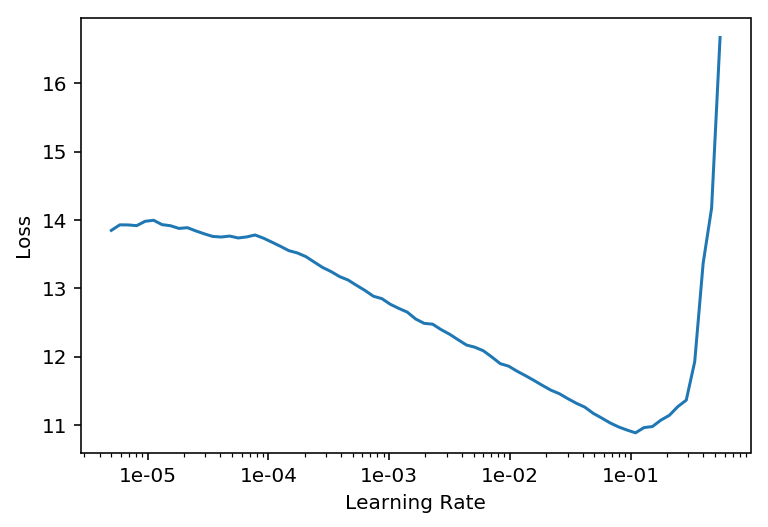

In [ ]:
learn.lr_find(start_lr=1e-6)
learn.recorder.plot()

In [ ]:
lr=1e-3

We can see that the multi-task model cut average age prediction error in half from 10 years to 5 years while holding the gender and race prediction accuracy almost the same.

In [ ]:
train_model(sz, bs, lr)

Total time: 04:55
epoch  train_loss  valid_loss  accuracy_gender  accuracy_race  l1loss_age
1      3.820566    3.185576    0.920275         0.806619       6.798038    (00:59)
2      3.146525    2.937081    0.925687         0.821607       6.007229    (00:59)
3      2.635532    2.604086    0.938385         0.844296       5.797429    (00:59)
4      2.222774    2.521048    0.938801         0.856162       5.449217    (00:59)
5      1.979625    2.446472    0.941091         0.859076       5.466319    (00:59)



Also, we run the multi-task model once instead of three time for the single-task models (all four models have similar run time).

## Inspect results of the multi-task model

Now let's look at the result on validation set to make sure things work.

In [ ]:
preds = learn.get_preds()

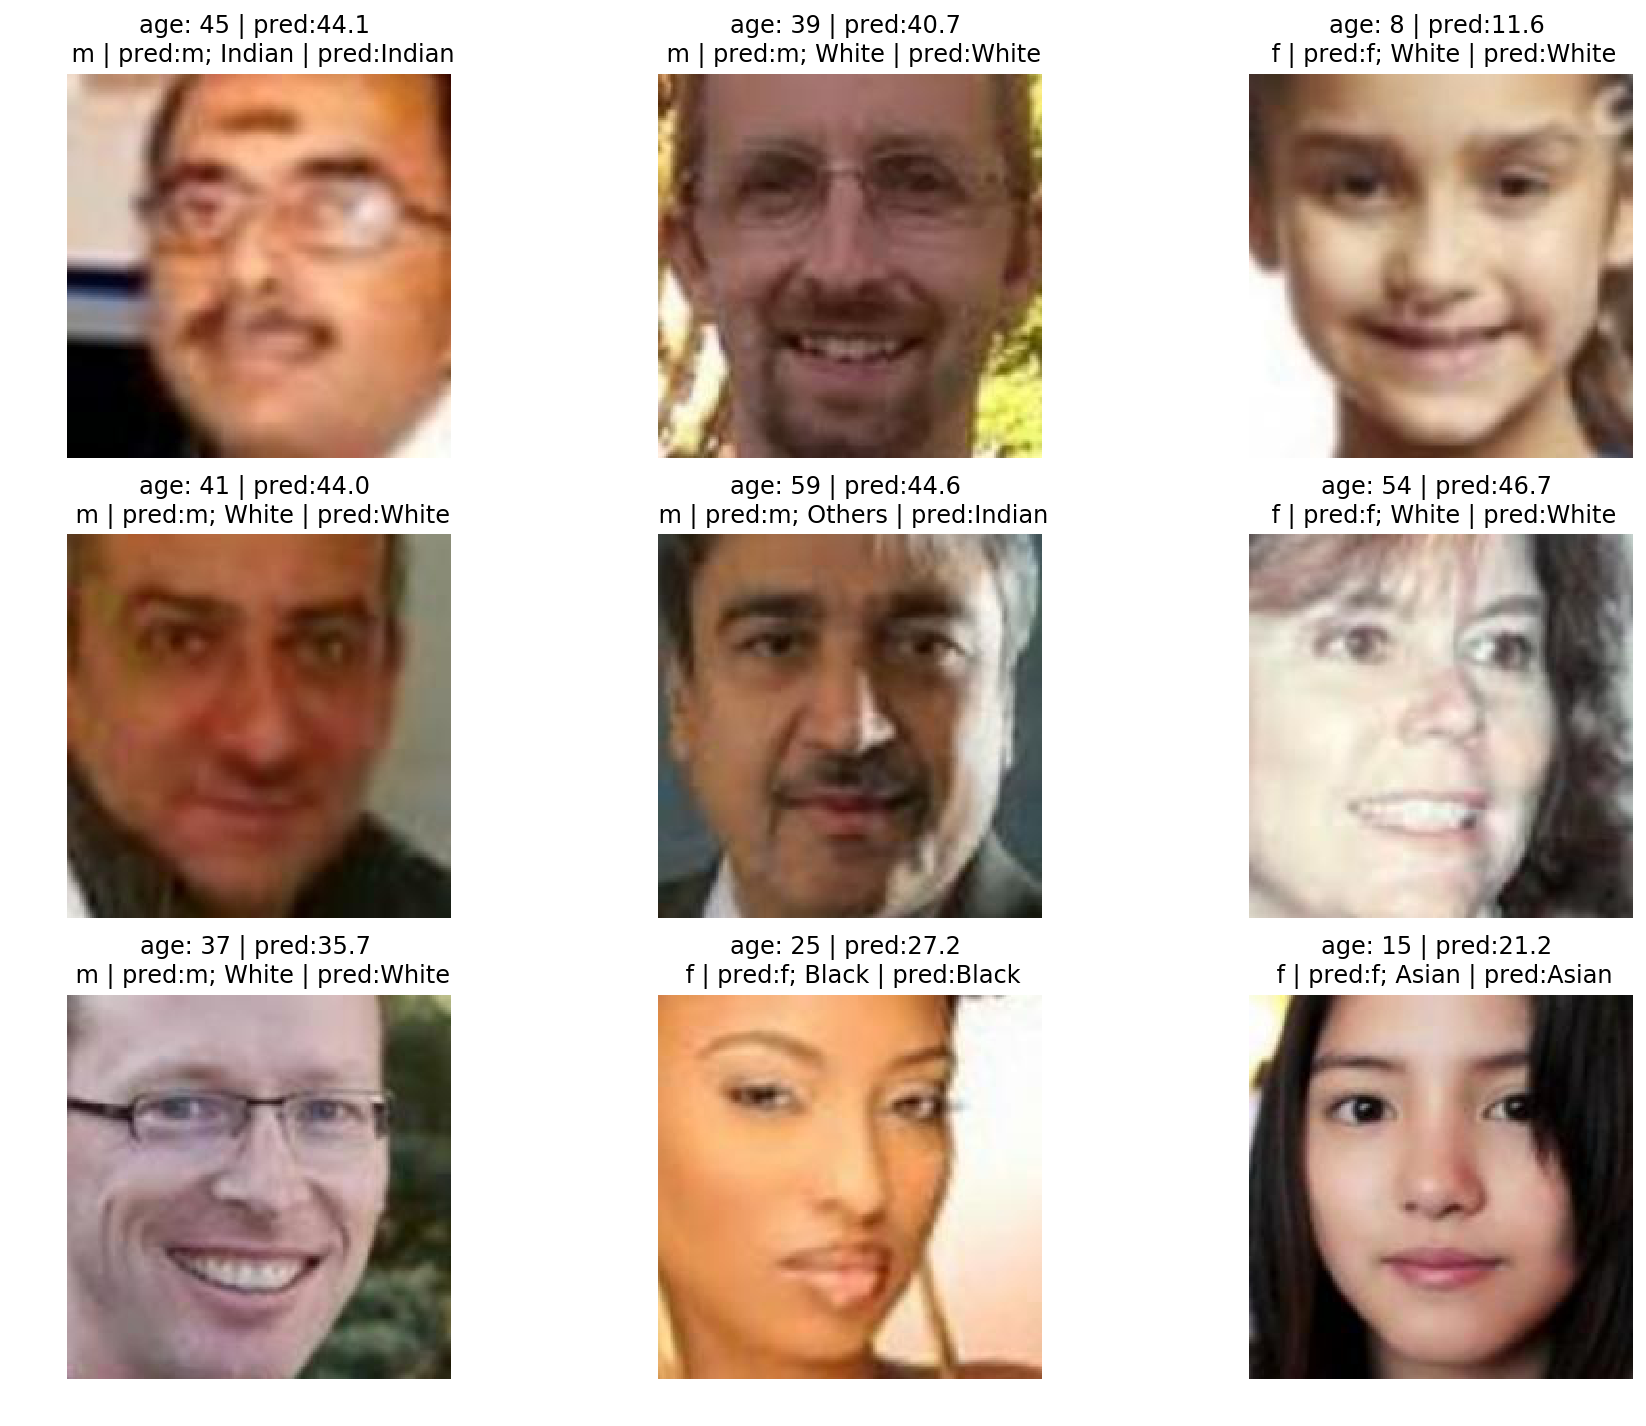

In [ ]:
df_val = df[df.is_train==0]

nr, nc = 3, 3
fig, axs = plt.subplots(nrows=nr, ncols=nc, figsize=(5*nc, 4*nr))

inds_sample = np.random.choice(len(df_val), nr*nc, replace=False) 
for j, ind in enumerate(inds_sample):
    fn, age, gender, race, _ = df_val.iloc[ind].values

    o_gender, o_race, p_age = preds[1][ind].numpy().astype(int)
    p_gender=data.classes_gender[np.argmax(preds[0][ind][:data.c_gender])]
    p_race=data.classes_race[np.argmax(preds[0][ind][data.c_gender:data.c_gender+data.c_race])]
    p_age = max(0, preds[0][ind][-1])
    show_image(open_image(fn), axs[j//nc, j%nc])
    axs[j//nc, j%nc].set(title=f'age: {age} | pred:{p_age:.3} \n {gender} | pred:{p_gender}; {race} | pred:{p_race}')

Seems fine.

We can also take a look at the true v.s. predicted age.

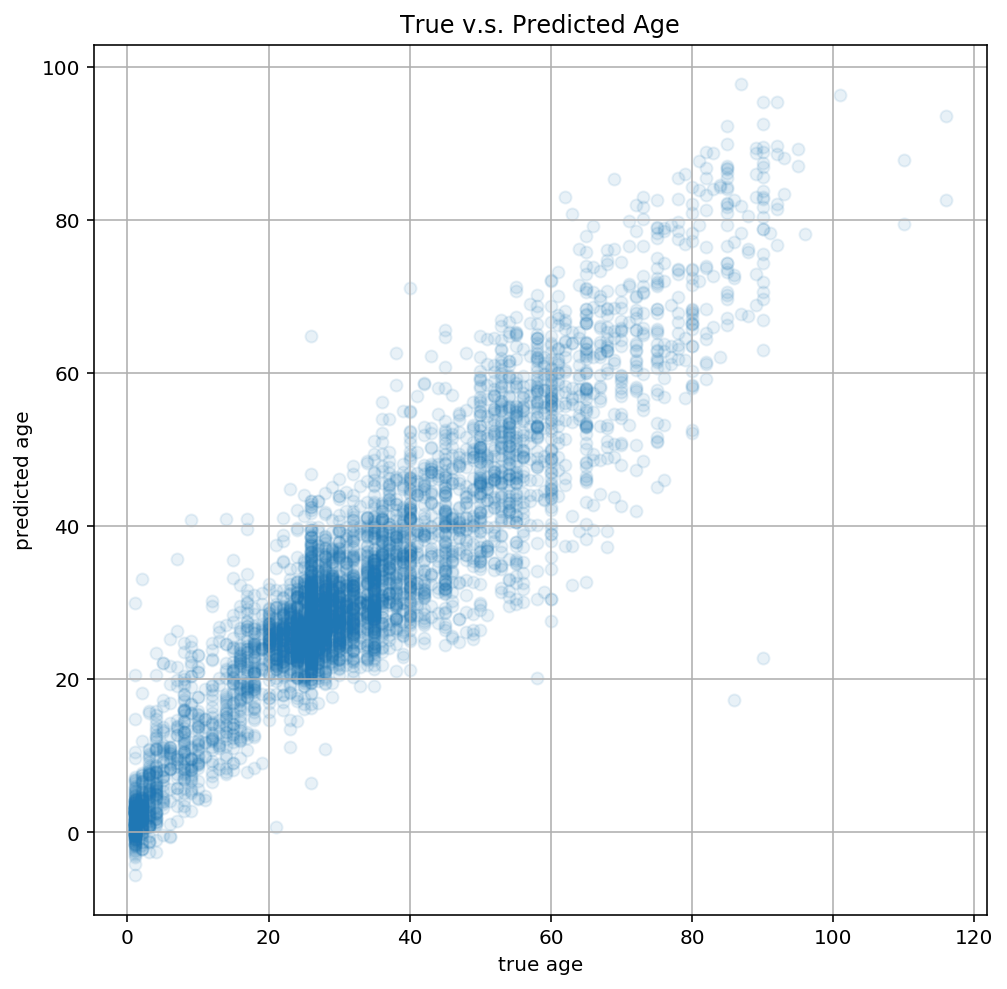

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(df_val.age, preds[0][:,-1], alpha=.1)
plt.xlabel('true age')
plt.ylabel('predicted age')
plt.title('True v.s. Predicted Age')
plt.grid()

## Closing comments

In this notebook we showed:
1. an example of a multi-task deep learning model: predicting gender, race (both classification tasks), and age (a regression task), respectively, based on the face image;
2. that the multi-task model makes better predictions than the individual model; and
2. how to use the fastai library to implement the model.

Hopefully this convinces you to 
1. try building a multi-task model when related labels are available (it is very common in real life data) 
2. try using fastai library for it as it is easy and provides best practices out of the box.

We haven't considered a lot of things.
1. We've only scratched the surface of multi-task learning. There are a large variety of techniques to learn and experiment. Wikipedia and Sebastian Ruder's [article](http://ruder.io/multi-task/) are good reference.
2. We kept the model building part simple on purpose to focus on the multi-task part. We didn't experiment with model architecture including the pretrained backbone and the top layers, we didn't tune dropout, and we didn't consider progressively increasing image size for training, a effective technique taught by fastai. In a real world application these are worth considering and testing, and fastai library usually makes it easy.